In [2]:
import numpy as np 
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.operators import PolynomialTensor
from qiskit_nature.second_q.properties import ElectronicDipoleMoment
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCC
from qiskit.primitives import Estimator
from qiskit_algorithms.optimizers import COBYLA , SLSQP, L_BFGS_B, SPSA, NELDER_MEAD
from qiskit_algorithms import VQE
from qiskit_algorithms.eigensolvers import NumPyEigensolver
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Statevector
#from qiskit.utils import QuantumInstance

In [3]:

driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)
problem = driver.run()
hamiltonian = problem.hamiltonian

dipole: ElectronicDipoleMoment  = problem.properties.electronic_dipole_moment
mapper = JordanWignerMapper()
dipole_ops = dipole.second_q_ops()

# Lấy toán tử moment lưỡng cực từ phương Z (vì X và Y rỗng)
x_dipole_op = dipole_ops["XDipole"]
y_dipole_op = dipole_ops["YDipole"]
z_dipole_op = dipole_ops["ZDipole"]

qubit_dipole_ops = {
    "XDipole": mapper.map(x_dipole_op),
    "YDipole": mapper.map(y_dipole_op),
    "ZDipole": mapper.map(z_dipole_op),
}

qubit_dipole_ops_matrix = {
    "XDipole": qubit_dipole_ops["XDipole"].to_matrix(),
    "YDipole": qubit_dipole_ops["YDipole"].to_matrix(),
    "ZDipole": qubit_dipole_ops["ZDipole"].to_matrix(),
}

second_q_op = hamiltonian.second_q_op()
qubit_jw_op = mapper.map(second_q_op) 


ansatz = UCC(
    num_spatial_orbitals = problem.num_spatial_orbitals, #2
    num_particles = problem.num_particles, # [1, 1]
    excitations='sd',
    qubit_mapper=mapper,
    initial_state=HartreeFock(
        num_spatial_orbitals = problem.num_spatial_orbitals,
        num_particles = problem.num_particles, 
        qubit_mapper=mapper,
    ),
    reps=1,

)

estimator = Estimator()
optimizer = SLSQP(maxiter=200)
vqe = VQE(estimator, ansatz, optimizer)
res = vqe.compute_minimum_eigenvalue(qubit_jw_op)

numpy_solver = NumPyEigensolver()
exact_result = numpy_solver.compute_eigenvalues(qubit_jw_op)
ref_value = exact_result.eigenvalues

H_0 = qubit_jw_op # H_0 (static) dưới dạng SparsePauliOp
H_static = H_0.to_matrix()  # Matrix of 

z_dipole_qubit = qubit_dipole_ops["ZDipole"]  # Toán tử moment lưỡng cực Z dưới dạng SparsePauliOp
z_dipole_matrix = z_dipole_qubit.to_matrix()  # Ma trận của toán tử moment lưỡng cực Z

def Hamilton_SP(t, H_0, z_dipole_qubit, E0, Gamma):
    t_float = float(t)  # Chuyển đổi t sang float 
    E_t = (E0 / np.pi) * Gamma / (Gamma**2 + t_float**2)
    V_t = E_t*z_dipole_qubit
    H_total_q = H_0 + V_t
    return H_total_q

import qiskit

from scipy.linalg import expm
def time_dependent(num_qubits : int , H_total_t,t):
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    for qubit in range(num_qubits//2, num_qubits):
        qc.x(qubit)

    if not np.allclose(H_total_t(t).to_matrix(), np.conj(H_total_t(t).to_matrix()).T):    
        raise ValueError("The Hamiltonian is not Hermitian.")    
    
    time_points = np.linspace(0,t,100)

    # Calculate the integral of H(t) using numerical approximation (e.g., trapezoidal rule)
    integral = np.zeros_like(H_total_t, dtype=complex)

    for i in range(len(time_points) - 1):
        dt = float(time_points[i+1] - time_points[i])
        integral += (H_total_t(time_points[i]) + H_total_t(time_points[i + 1])) / 2 * dt

   # Compute the matrix exponential
    U = expm(-1j * integral)  

      # Check if U is unitary
    if not np.allclose(U @ U.conj().T, np.eye(U.shape[0])):
        raise ValueError("The resulting matrix U is not unitary.")
        
    #return U matrix
    """
    # Create a UnitaryGate from the unitary_matrix
    unitary_gate = UnitaryGate(U)

    # Append the unitary_gate to the quantum circuit
    qc.append(unitary_gate, range(qc.num_qubits))
    """
    # from qoop.core.state import specific_matrix
    
    # return specific_matrix(U)
    return U
    

def time_dependent_integral(H_total_t, t):
    """create U circuit from h_opt and time t
    
    Args:
        - qc (QuantumCircuit): Init circuit
        - h_opt: Hamiltonian
        - t (float): time
        
    Returns:
        - QuantumCircuit: the added circuit
    """
    # Ensure h_opt is Hermitian
    if not np.allclose((H_total_t(t).to_matrix()), np.conj(H_total_t(t).to_matrix()).T):
        raise ValueError("The Hamiltonian is not Hermitian.")

    time_points = np.linspace(0, t, 100)
    # Calculate the integral of H(t) using numerical approximation (e.g., trapezoidal rule)
    integral = np.zeros_like(H_total_t, dtype=complex)  # Initialize integral as a matrix
    
    for i in range(len(time_points) - 1):
        dt = float(time_points[i + 1] - time_points[i])
        integral += (H_total_t(time_points[i]) + H_total_t(time_points[i + 1])) / 2 * dt

    return integral    

def H_time(t):
    Gamma = 0.25
    E0 = 0.01
    return Hamilton_SP(t, H_0, z_dipole_qubit, E0, Gamma)

static_pauli_op = H_0 
static_labels = static_pauli_op.paulis.to_labels()
dipole_pauli_op = z_dipole_qubit
dipole_interaction_labels = dipole_pauli_op.paulis.to_labels()
combined_unique_labels = list(dict.fromkeys(static_labels + dipole_interaction_labels))
num_qubits = H_0.num_qubits
N = num_qubits # num_qubits = 4

circuit = ansatz.assign_parameters(res.optimal_parameters)
psi_0_vqe = np.array(Statevector(circuit).data)


In [4]:
from qiskit.quantum_info import random_unitary
from qiskit.circuit.library import UnitaryGate
from sync import cost as cost_func
from sync import circuit, constant
import pennylane.numpy as np
import pennylane as qml
%load_ext autoreload
%autoreload 2

In [5]:
def pennylane_ansatz_from_qiskit_pauli_evo(thetas, num_qubits, pauli_labels, num_layers):
    """
Tạo một ansatz Pennylane tương đương với việc áp dụng một chuỗi các PauliEvolutionGate của Qiskit.
Cấu trúc của Qiskit ansatz: U(theta) = product_L (product_k exp(-i * theta_Lk * P_k))
Trong Pennylane, qml.exp(op, coeff) thực hiện exp(coeff * op).
Chúng ta muốn thực hiện exp(-i * theta_Lk * P_k), vậy:
    op = P_k (dưới dạng PauliWord của Pennylane)
    coeff = -1j * theta_Lk

Args:
    thetas (np.ndarray): Mảng 1D các tham số theta, được làm phẳng (flattened).
                            Thứ tự phải khớp với cách Qiskit ansatz sử dụng chúng
                            (tức là, tất cả các theta cho lớp 1, sau đó tất cả cho lớp 2, v.v.).
    num_qubits (int): Số qubit của hệ thống.
    pauli_labels (list[str]): Danh sách các chuỗi Pauli CỐ ĐỊNH (P_k)
                                    dưới dạng chuỗi ký tự kiểu Qiskit (ví dụ: "IXYZ", "ZZI").
                                    Độ dài mỗi chuỗi phải bằng num_qubits.
    num_layers (int): Số lớp (N_L) của ansatz.
"""
    if not pauli_labels:
        raise ValueError("pauli_labels không được rỗng.")

    num_params_per_layer = len(pauli_labels)
    num_params_expected = num_params_per_layer * num_layers

    if len(thetas) != num_params_expected:
        raise ValueError(f"Số lượng tham số `thetas` không khớp. Mong đợi {num_params_expected}, nhận được {len(thetas)}.")
    
    param_idx = 0
    for _ in range(num_layers):
        for pauli_qiskit_str in pauli_labels:
            if len(pauli_qiskit_str) != num_qubits:
                raise ValueError(f"Chuỗi Pauli '{pauli_qiskit_str}' không khớp num_qubits.")
            
            pennylane_observable = None
            if all(c == 'I' for c in pauli_qiskit_str):
                if num_qubits > 0:
                    pennylane_observable = qml.Identity(0)
                    for i_w in range(1, num_qubits): pennylane_observable @= qml.Identity(i_w)
                elif num_qubits == 0: pennylane_observable = qml.Identity(0)
                else: raise ValueError("Số qubit phải không âm.")
            else:
                try: pennylane_observable = qml.pauli.string_to_pauli_word(pauli_qiskit_str)
                except AttributeError:

                    ops_list = []
                    for i_wire in range(num_qubits):
                        char = pauli_qiskit_str[i_wire]
                        if char == 'X': ops_list.append(qml.PauliX(i_wire))
                        elif char == 'Y': ops_list.append(qml.PauliY(i_wire))
                        elif char == 'Z': ops_list.append(qml.PauliZ(i_wire))
                        elif char == 'I': pass
                        else: raise ValueError(f"Ký tự Pauli không hợp lệ '{char}'")

                    if not ops_list and num_qubits > 0:
                         pennylane_observable = qml.Identity(0)
                         for i_w in range(1, num_qubits): pennylane_observable @= qml.Identity(i_w)
                    elif ops_list: pennylane_observable = qml.prod(*ops_list)
                    else: raise ValueError(f"Không tạo được observable từ '{pauli_qiskit_str}'")
            if pennylane_observable is not None: qml.exp(pennylane_observable, -1j * thetas[param_idx])
            param_idx += 1
# --- Kết thúc hàm ansatz ---

In [4]:
import math
from qiskit.quantum_info import Operator
import pennylane as qml
from numpy.random import Generator, PCG64
#from pennylane import numpy as pnp 
import numpy as np
import pennylane.numpy as pnp
import matplotlib.pyplot as plt
from qiskit.quantum_info import random_unitary

num_qubits = H_0.num_qubits #num_qubits
num_layers = 6 #num_ansatz_layers
#constant_error = 1e-6 


pauli_labels = combined_unique_labels
num_thetas = len(pauli_labels) * num_layers

# num_blocks = num_qubits*(num_qubits-1)//2
# active_blocks =  np.ones(num_blocks * num_layers)
# thetas ban đầu
# if num_thetas > 0:
#     thetas = pnp.array(np.random.uniform(0, 2*np.pi, num_thetas), requires_grad=True)
# else:
#     thetas = pnp.array([], requires_grad=False)
rng = Generator(PCG64())  
#args = parser.parse_args()
#thetas = np.random.uniform(0, 2*np.pi, constant.num_params_on_active_blocks(active_blocks), requires_grad=True)
#thetas = np.random.uniform(0,2*np.pi,num_thetas,requires_grad=True)

# Phương pháp random 
thetas = pnp.array(2*math.pi*rng.random(size = num_thetas), requires_grad=True)

# Phương pháp small random
# thetas = pnp.array(args.small*rng.random(size = num_thetas), requires_grad=True)

#Phương pháp constrained initialization

times = np.linspace(0, 300, 50)

# Danh sách lưu trữ
all_optimized_U_theta_t = {}
all_psi_t_pennylane = {}
#all_costs_history_per_t = {}
frobenius_norms_over_time = {} 


print("Bắt đầu mô phỏng tiến hóa thời gian bằng Pennylane")
for t in times:
    print(f"\n--- Thời điểm t = {t:.4f} ---")

    target = time_dependent(num_qubits, H_time, t)
    
    def cost(thetas): 
        ansatz_matrix = qml.matrix(pennylane_ansatz_from_qiskit_pauli_evo,
                                   wire_order=list(range(num_qubits)) 
                                  )(
                                      thetas,
                                      num_qubits,
                                      pauli_labels,
                                      num_layers
                                  )
        return cost_func.c_hst(ansatz_matrix, target)

    steps = 300
    costs = []
    opt = qml.AdamOptimizer(stepsize=0.01)
    
    for n in range(steps):
        thetas, prev_cost = opt.step_and_cost(cost, thetas)
        if (n + 1) % (steps // 2 if steps >=2 else 1) == 0: 
            print(f"    t={t:.2f}, Opt. step {n+1}/{steps}, Cost: {prev_cost:.6f}")
        if prev_cost < constant.error:
                print(f"    Đạt ngưỡng lỗi ở bước {n+1} cho t={t:.2f}")
               # break
        costs.append(prev_cost)

    U_theta_t = None
    if num_thetas > 0:
        U_theta_t = qml.matrix(pennylane_ansatz_from_qiskit_pauli_evo,
                                            wire_order=range(num_qubits) #if num_qubits > 0 else [0]
                                           )(
                                               thetas, 
                                               num_qubits,
                                               pauli_labels,
                                               num_layers
                                           )
    elif num_qubits > 0:
        U_theta_t = np.eye(2**num_qubits, dtype=complex)
    else:
        U_theta_t = np.array([[1.0+0.j]])


    all_optimized_U_theta_t[t] = U_theta_t.numpy() if hasattr(U_theta_t, 'numpy') else np.asarray(U_theta_t)

    norm_diff = np.linalg.norm(U_theta_t - target, 'fro')
    frobenius_norms_over_time[t] = norm_diff
    # Công thức: F(A, B) = sqrt(Tr((A-B)^H * (A-B)))
    # diff_dm = dm_exact - dm_approx
    #frobenius_dist = qml.math.norm(diff_dm, ord='fro')
    # frobenius_dist = qml.math.sqrt(qml.math.real(qml.math.trace(qml.math.dot(qml.math.conj(qml.math.transpose(diff_dm)), diff_dm))))
    # all_frobenius_distances[t] = frobenius_dist

    print(f"  Frobenius Norm ||U(θ*) - V(t)|| = {norm_diff:.6e}")

    if num_qubits >= 0 : 
        psi_0_col = psi_0_vqe.reshape(-1, 1)
        U_mat_np_for_psi = all_optimized_U_theta_t[t]       

        psi_t_col_approx = U_mat_np_for_psi @ psi_0_col
        psi_t_approx = psi_t_col_approx.flatten()
        all_psi_t_pennylane[t] = psi_t_approx




Bắt đầu mô phỏng tiến hóa thời gian bằng Pennylane

--- Thời điểm t = 0.0000 ---
    t=0.00, Opt. step 150/300, Cost: 0.146449
    t=0.00, Opt. step 300/300, Cost: 0.146449
  Frobenius Norm ||U(θ*) - V(t)|| = 2.724976e+00

--- Thời điểm t = 6.1224 ---
    t=6.12, Opt. step 150/300, Cost: 0.146447
    t=6.12, Opt. step 300/300, Cost: 0.146450
  Frobenius Norm ||U(θ*) - V(t)|| = 5.779516e+00

--- Thời điểm t = 12.2449 ---
    Đạt ngưỡng lỗi ở bước 90 cho t=12.24
    Đạt ngưỡng lỗi ở bước 91 cho t=12.24
    Đạt ngưỡng lỗi ở bước 92 cho t=12.24
    Đạt ngưỡng lỗi ở bước 93 cho t=12.24
    Đạt ngưỡng lỗi ở bước 94 cho t=12.24
    Đạt ngưỡng lỗi ở bước 95 cho t=12.24
    Đạt ngưỡng lỗi ở bước 96 cho t=12.24
    Đạt ngưỡng lỗi ở bước 97 cho t=12.24
    Đạt ngưỡng lỗi ở bước 98 cho t=12.24
    Đạt ngưỡng lỗi ở bước 99 cho t=12.24
    Đạt ngưỡng lỗi ở bước 100 cho t=12.24
    Đạt ngưỡng lỗi ở bước 101 cho t=12.24
    Đạt ngưỡng lỗi ở bước 102 cho t=12.24
    Đạt ngưỡng lỗi ở bước 103 cho t=12.2

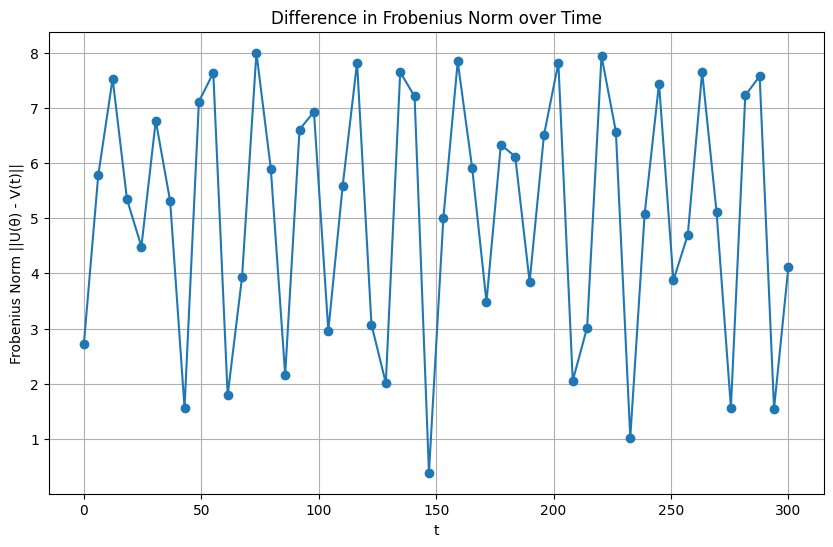

In [5]:
if frobenius_norms_over_time:
    sorted_times_for_plot = sorted(frobenius_norms_over_time.keys())
    norm_values_for_plot = [frobenius_norms_over_time[t] for t in sorted_times_for_plot]
    
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_times_for_plot, norm_values_for_plot, marker='o', linestyle='-', label='Frobenius Norm ')
    
    plt.xlabel("t")
    plt.ylabel("Frobenius Norm ||U(θ) - V(t)||")
    plt.title("Difference in Frobenius Norm over Time")
    plt.grid(True)
    plt.show()
else:
    print("Không có dữ liệu Frobenius norm để vẽ đồ thị.")

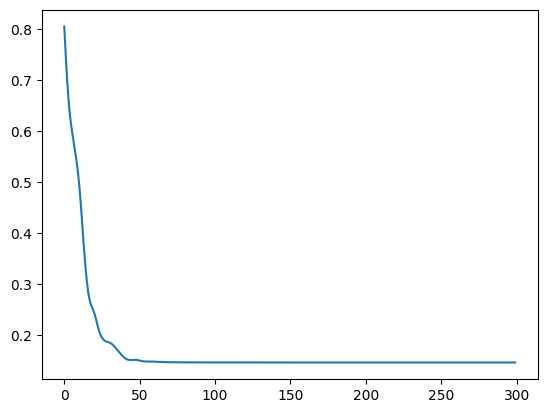

In [107]:
import matplotlib.pyplot as plt
plt.plot(costs)

Đã trích xuất thành công 300 giá trị cost.


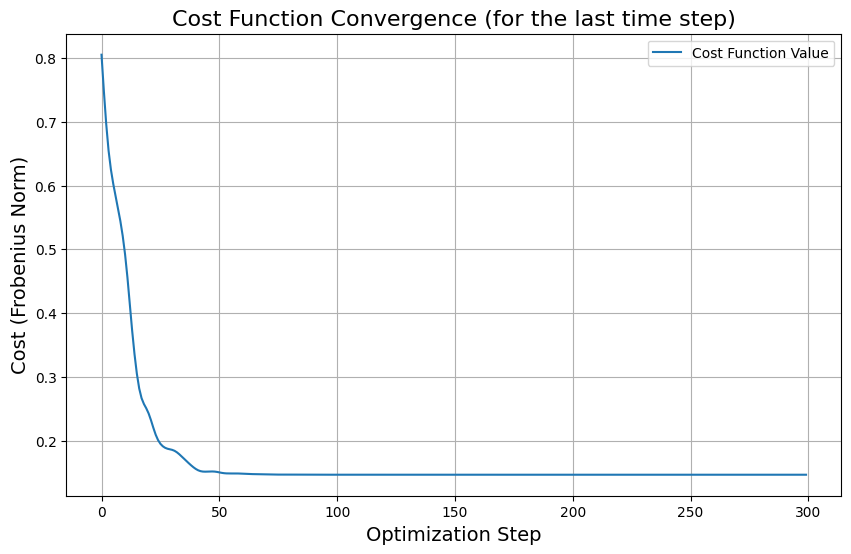

In [108]:
# CELL MỚI: TRÍCH XUẤT GIÁ TRỊ TỪ LIST 'COSTS' VÀ VẼ ĐỒ THỊ

import matplotlib.pyplot as plt
import numpy as np

try:
    # --- Bước 1: Kiểm tra xem biến 'costs' có tồn tại không ---
    if 'costs' not in locals():
        raise NameError("Không tìm thấy biến 'costs'. Vui lòng chạy lại một ô code có quá trình tối ưu hóa để tạo ra biến này.")

    # --- Bước 2: Trích xuất giá trị số (float) từ mỗi tensor ---
    # Dùng list comprehension để tạo một list mới chỉ chứa các con số
    numeric_costs = [float(c) for c in costs]
    
    print(f"Đã trích xuất thành công {len(numeric_costs)} giá trị cost.")

    # --- Bước 3: Vẽ đồ thị ---
    plt.figure(figsize=(10, 6))
    
    # Trục x là các bước tối ưu, trục y là giá trị cost
    plt.plot(numeric_costs, label='Cost Function Value')
    
    plt.xlabel("Optimization Step", fontsize=14)
    plt.ylabel("Cost (Frobenius Norm)", fontsize=14)
    plt.title("Cost Function Convergence (for the last time step)", fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Đã xảy ra lỗi không mong muốn: {e}")


In [109]:
# CELL MỚI: XUẤT GIÁ TRỊ TỪ LIST 'COSTS' RA FILE

import numpy as np

output_filename = "last_run_cost_history.txt"

try:
    # --- Bước 1: Kiểm tra sự tồn tại của biến 'costs' ---
    if 'costs' not in locals():
        raise NameError("Không tìm thấy biến 'costs'. Vui lòng chạy lại một ô code có quá trình tối ưu hóa để tạo ra biến này.")

    # --- Bước 2: Trích xuất giá trị số (float) từ mỗi tensor ---
    # Dùng list comprehension để tạo một list mới chỉ chứa các con số
    numeric_costs = [float(c) for c in costs]
    
    print(f"Đã trích xuất thành công {len(numeric_costs)} giá trị cost từ lần chạy cuối.")

    # --- Bước 3: Ghi kết quả ra file ---
    print(f"Đang ghi kết quả ra file '{output_filename}'...")
    
    with open(output_filename, "w") as f:
        # Ghi dòng tiêu đề cho các cột
        f.write("# Optimization_Step   Cost_Value\n")
        
        # Lặp qua dữ liệu và ghi ra file
        for step, cost_value in enumerate(numeric_costs):
            # step + 1 để bắt đầu từ bước 1
            f.write(f"{step + 1:<20} {cost_value:<.12f}\n")
            
    print(f"\nHoàn tất! Đã lưu thành công lịch sử cost vào file '{output_filename}'.")

except Exception as e:
    print(f"Đã xảy ra lỗi không mong muốn: {e}")

Đã trích xuất thành công 300 giá trị cost từ lần chạy cuối.
Đang ghi kết quả ra file 'last_run_cost_history.txt'...

Hoàn tất! Đã lưu thành công lịch sử cost vào file 'last_run_cost_history.txt'.


In [106]:
print(costs)

[tensor(0.80535871, requires_grad=True), tensor(0.74841483, requires_grad=True), tensor(0.69659084, requires_grad=True), tensor(0.65487342, requires_grad=True), tensor(0.62501479, requires_grad=True), tensor(0.60243662, requires_grad=True), tensor(0.58328883, requires_grad=True), tensor(0.56453916, requires_grad=True), tensor(0.54444847, requires_grad=True), tensor(0.52110709, requires_grad=True), tensor(0.49217902, requires_grad=True), tensor(0.45614556, requires_grad=True), tensor(0.4145074, requires_grad=True), tensor(0.37272173, requires_grad=True), tensor(0.33585879, requires_grad=True), tensor(0.30498323, requires_grad=True), tensor(0.28173934, requires_grad=True), tensor(0.2665295, requires_grad=True), tensor(0.25738773, requires_grad=True), tensor(0.25061347, requires_grad=True), tensor(0.24255475, requires_grad=True), tensor(0.23193619, requires_grad=True), tensor(0.22006585, requires_grad=True), tensor(0.209167, requires_grad=True), tensor(0.20074503, requires_grad=True), ten

In [7]:
from qiskit.quantum_info import Operator
all_psi_t_exact = {} 

times = np.linspace(0,300,50)

for t in times:

    U_true_at_t_circuit = time_dependent(num_qubits, H_time, t)
    U_true_at_t_matrix = Operator(U_true_at_t_circuit).data
    
    psi_0_vqe_col = psi_0_vqe.reshape(-1,1)
    psi_t_current_col_exact = U_true_at_t_matrix @ psi_0_vqe_col
    psi_t_current_exact = psi_t_current_col_exact.flatten()
    
    all_psi_t_exact[t] = psi_t_current_exact

{0.0: 0.9999497760234555, 6.122448979591836: 0.9999999999999085, 12.244897959183673: 0.9999113486510689, 18.36734693877551: 0.9999999999999081, 24.489795918367346: 0.9999999999998548, 30.612244897959183: 0.9999306321462119, 36.73469387755102: 0.9999999999999019, 42.857142857142854: 0.9999999999998532, 48.97959183673469: 0.9998986492010139, 55.10204081632653: 0.9999999999999063, 61.224489795918366: 0.999948561580776, 67.3469387755102: 0.9999999999999121, 73.46938775510203: 0.9999558341400567, 79.59183673469387: 0.9999999999999065, 85.71428571428571: 0.9999630078181356, 91.83673469387755: 0.99999998714428, 97.95918367346938: 0.9999879719919128, 104.08163265306122: 0.9999999978066707, 110.20408163265306: 0.9999708969286484, 116.3265306122449: 0.9999999999999092, 122.44897959183673: 0.9999904965641867, 128.57142857142856: 0.9999999999998699, 134.6938775510204: 0.9999828298230371, 140.81632653061223: 0.9999999708991953, 146.93877551020407: 0.9999311621147038, 153.0612244897959: 0.9999999999

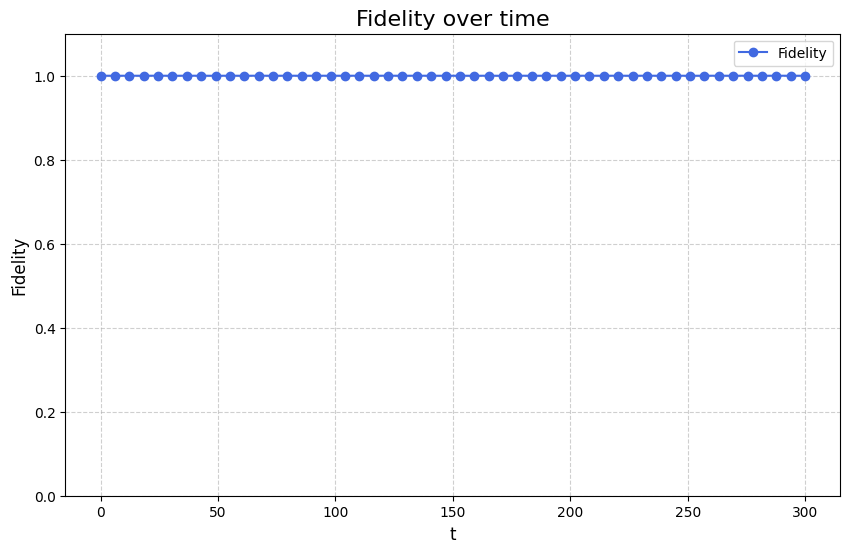

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Công thức: Fidelity = |<psi_exact|psi_train>|^2

fidelities_over_time = {}
for t in all_psi_t_pennylane.keys():
    psi_exact = all_psi_t_exact[t]
    psi_train = all_psi_t_pennylane[t]
    

    # dm_exact = qml.math.dm_from_state_vector(psi_exact)
    # dm_train = qml.math.dm_from_state_vector(psi_train)

    # fidelity = qml.math.fidelity(dm_exact, dm_train)
    # fidelities_over_time[t] = fidelity

    inner_product = np.dot(psi_exact.conj(), psi_train)

    fidelity = np.abs(inner_product)**2
    fidelities_over_time[t] = fidelity

print(fidelities_over_time)


sorted_times = sorted(fidelities_over_time.keys())
sorted_fidelities = [fidelities_over_time[t] for t in sorted_times]

plt.figure(figsize=(10, 6))

plt.plot(sorted_times, sorted_fidelities, marker='o', linestyle='-', color='royalblue', label='Fidelity')

plt.title('Fidelity over time', fontsize=16)
plt.xlabel('t', fontsize=12)
plt.ylabel('Fidelity', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.ylim(0,1.1)

plt.show()

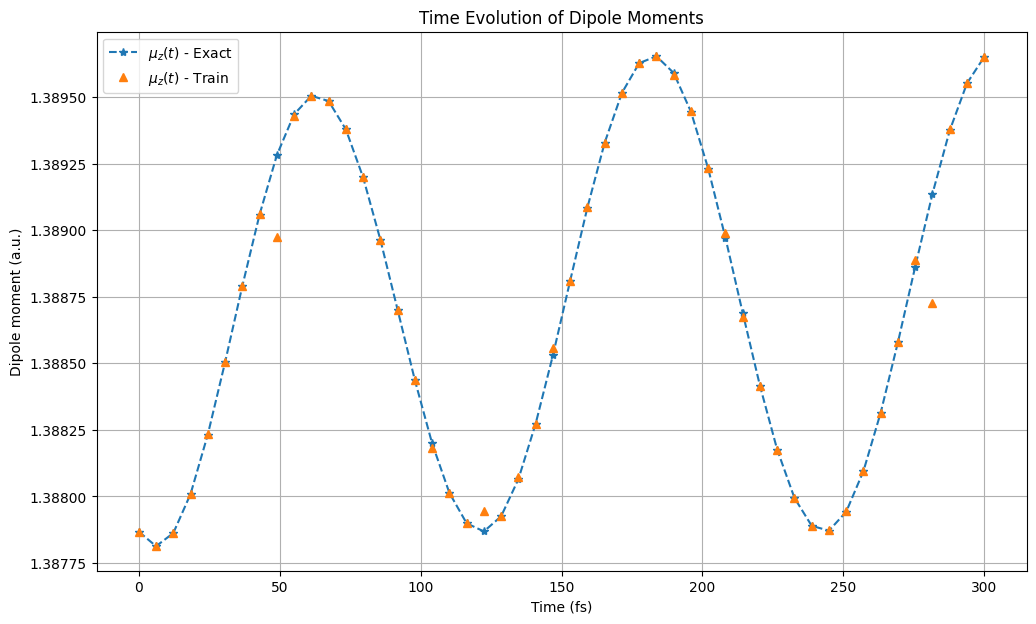

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp 
import qiskit 

def calculate_expectation_value(state_vector_flat, pauli_op_sparse):
    if pauli_op_sparse is None or state_vector_flat is None:
        return np.nan
    sv = Statevector(state_vector_flat)
    try:
        exp_val = sv.expectation_value(pauli_op_sparse)
        return exp_val.real 
    except Exception as e_exp:
        print(f"    Lỗi khi tính giá trị kỳ vọng: {e_exp}")
        return np.nan

times_plot_exact = []
mux_plot_exact = []
muy_plot_exact = []
muz_plot_exact = []

times_plot_pennylane = []
mux_plot_pennylane = []
muy_plot_pennylane = []
muz_plot_pennylane = []

# Pennylane
sorted_times_pennylane = sorted(all_psi_t_pennylane.keys())

for t_current in sorted_times_pennylane:
    psi_t_pennylane = all_psi_t_pennylane[t_current]

    if psi_t_pennylane is not None:
        # print(f"  Tính toán cho t = {t_current:.4f} (Pennylane)") 
        times_plot_pennylane.append(t_current)
        mux_plot_pennylane.append(calculate_expectation_value(psi_t_pennylane, x_dipole_qubit if 'dipole_qubit_X' in locals() and x_dipole_qubit is not None else None))
        muy_plot_pennylane.append(calculate_expectation_value(psi_t_pennylane, y_dipole_qubit if 'dipole_qubit_Y' in locals() and y_dipole_qubit is not None else None))
        muz_plot_pennylane.append(calculate_expectation_value(psi_t_pennylane, z_dipole_qubit))
    else:
        times_plot_pennylane.append(t_current)
        mux_plot_pennylane.append(np.nan)
        muy_plot_pennylane.append(np.nan)
        muz_plot_pennylane.append(np.nan)

times_pennylane = np.array(times_plot_pennylane)
mux_pennylane = np.array(mux_plot_pennylane)
muy_pennylane = np.array(muy_plot_pennylane)
muz_pennylane = np.array(muz_plot_pennylane)

# Exact
sorted_times = sorted(all_psi_t_exact.keys())

for t_current in sorted_times:
    psi_t = all_psi_t_exact[t_current]
    
    if psi_t is not None: 
        times_plot_exact.append(t_current)

        current_mux = calculate_expectation_value(psi_t, x_dipole_qubit if 'dipole_qubit_X' in locals() and x_dipole_qubit is not None else None)
        current_muy = calculate_expectation_value(psi_t, y_dipole_qubit if 'dipole_qubit_Y' in locals() and y_dipole_qubit is not None else None)
        current_muz = calculate_expectation_value(psi_t, z_dipole_qubit) 

        mux_plot_exact.append(current_mux)
        muy_plot_exact.append(current_muy)
        muz_plot_exact.append(current_muz)
    else:

        times_plot_exact.append(t_current)
        mux_plot_exact.append(np.nan)
        muy_plot_exact.append(np.nan)
        muz_plot_exact.append(np.nan)

times_exact = np.array(times_plot_exact)
mux_exact = np.array(mux_plot_exact)
muy_exact = np.array(muy_plot_exact)
muz_exact = np.array(muz_plot_exact)

plt.figure(figsize=(12, 7))

# Vẽ đường "Exact" 
if  mux_exact.size > 0 and np.any(~np.isnan(mux_exact)) and np.any(mux_exact != 0):
    plt.plot(times_exact, mux_exact, label="$\mu_x(t)$ - Exact", marker='x', linestyle='--')
if muy_exact.size > 0 and np.any(~np.isnan(muy_exact)) and np.any(muy_exact != 0):
    plt.plot(times_exact, muy_exact, label="$\mu_y(t)$ - Exact", marker='+', linestyle='--')
if muz_exact.size > 0 and np.any(~np.isnan(muz_exact)):
    plt.plot(times_exact, muz_exact, label="$\mu_z(t)$ - Exact", marker='*', linestyle='--')

# Vẽ đường từ kết quả Pennylane
if mux_pennylane.size > 0 and np.any(~np.isnan(mux_pennylane)) and np.any(mux_pennylane != 0):
    plt.plot(times_pennylane, mux_pennylane, label="$\mu_x(t)$ - Train", marker='o', linestyle='-')
if muy_pennylane.size > 0 and np.any(~np.isnan(muy_pennylane)) and np.any(muy_pennylane != 0):
    plt.plot(times_pennylane, muy_pennylane, label="$\mu_y(t)$ - Train", marker='s', linestyle='-')
if muz_pennylane.size > 0 and np.any(~np.isnan(muz_pennylane)):
    plt.plot(times_pennylane, muz_pennylane, label="$\mu_z(t)$ - Train", marker='^', linestyle='')

plt.xlabel("Time (fs)")
plt.ylabel("Dipole moment (a.u.)")
plt.title("Time Evolution of Dipole Moments")


handles, labels = plt.gca().get_legend_handles_labels()
if labels:
    plt.legend()
    
#plt.xlim(0,300)
plt.grid(True)
plt.show()


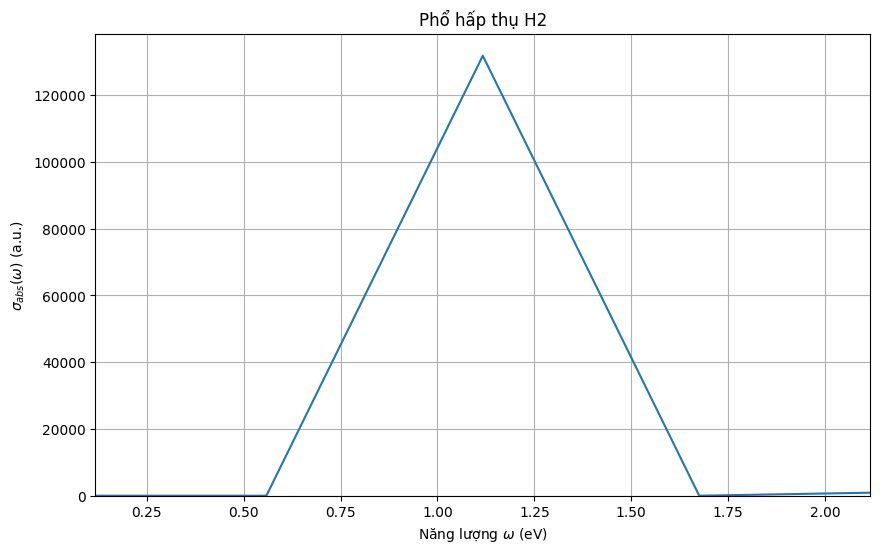

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import windows

# 1. Xác định bước thời gian và số điểm cho FFT
if len(times_plot_exact) < 2:
    print("Lỗi: Cần ít nhất 2 điểm thời gian để thực hiện FFT.")
    # Thoát hoặc xử lý lỗi phù hợp
else:
    dt_fourier = times_plot_exact[1] - times_plot_exact[0]
    N_points = len(times_plot_exact)

    # 2. Chuẩn bị tín hiệu moment lưỡng cực d_z(t)
    # Áp dụng hàm cửa sổ để giảm hiệu ứng rò rỉ phổ (tùy chọn nhưng khuyến khích)
    # window = windows.hann(N_points) # Ví dụ dùng cửa sổ Hanning
    mu_t = muz_plot_pennylane
    window = windows.blackman(N_points) # Cửa sổ Blackman thường tốt hơn
    d_z_t_windowed = muz_plot_pennylane * window

    # Tính biến đổi Fourier của d_z(t)
    d_z_omega = fft(d_z_t_windowed)
    
    # Tạo mảng tần số góc omega cho FFT
    # fftfreq trả về tần số theo chu kỳ (cycles/unit-time)
    # Nhân với 2*pi để ra tần số góc (radians/unit-time)
    omega_fft_full = fftfreq(N_points, dt_fourier) * 2 * np.pi

    # 3. Chuẩn bị tín hiệu trường điện từ E_z(t) và tính FFT
    def f_t_lorentz(t, E0, Gamma):
        E0 = 0.01
        Gamma = 0.25
        return (E0 / np.pi) * Gamma / (Gamma**2 + t**2)

    times_plot_exact_np = np.array(times_plot_exact)
    E0 =0.01
    Gamma = 0.25
    electric_field_z_t = f_t_lorentz(times_plot_exact_np, E0, Gamma)
    E_z_t_windowed = electric_field_z_t * window # Cũng nên áp dụng cửa sổ cho E(t)
    E_z_omega_full = fft(E_z_t_windowed)

    # 4. Tính alpha_zz(omega)
    # Chỉ xét các tần số dương vì phổ thường đối xứng
    # Sử dụng fftshift để đưa thành phần tần số 0 về giữa, sau đó lấy nửa phải
    
    # Dịch chuyển 0-frequency component về giữa mảng
    d_z_omega_shifted = fftshift(d_z_omega)
    E_z_omega_shifted = fftshift(E_z_omega_full)
    omega_fft_shifted = fftshift(omega_fft_full)

    # Lấy các chỉ số cho tần số dương (và có thể cả tần số 0 nếu muốn)
    # Vì đã dịch chuyển, các tần số dương nằm ở nửa sau của mảng
    positive_freq_indices = omega_fft_shifted >= 0 
    
    omega_positive = omega_fft_shifted[positive_freq_indices]
    d_z_omega_positive = d_z_omega_shifted[positive_freq_indices]
    E_z_omega_positive = E_z_omega_shifted[positive_freq_indices]
    
    # Tính alpha_zz(omega), tránh chia cho 0
    alpha_zz_omega = np.zeros_like(d_z_omega_positive, dtype=complex)
    # Ngưỡng nhỏ để tránh chia cho các giá trị E_z_omega rất gần 0
    valid_E_indices = np.abs(E_z_omega_positive) > 1e-9 
    
    alpha_zz_omega[valid_E_indices] = d_z_omega_positive[valid_E_indices] / E_z_omega_positive[valid_E_indices]

    # 5. Tính sigma_abs(omega)
    c_au = 137.035999084 # Tốc độ ánh sáng trong đơn vị nguyên tử (Hartree_energy*bohr/hbar)
    
    # sigma_abs = (4 * np.pi * omega / c) * Im[alpha]
    sigma_abs_omega = (4 * np.pi * omega_positive / c_au) * np.imag(alpha_zz_omega)
    
    # Loại bỏ các giá trị âm không vật lý của sigma (có thể xảy ra do nhiễu số học)
    sigma_abs_omega[sigma_abs_omega < 0] = 0

    # 6. Chuyển đổi omega sang eV để vẽ đồ thị (tùy chọn)
    # 1 Hartree (đơn vị năng lượng/tần số góc trong a.u.) = 27.211386245988 eV
    hartree_to_ev = 27.211386245988
    omega_ev = omega_positive * hartree_to_ev

    # 7. Vẽ phổ hấp thụ
    plt.figure(figsize=(10, 6))
    plt.plot(omega_ev, sigma_abs_omega)
    plt.xlabel("Năng lượng $\omega$ (eV)")
    plt.ylabel("$\sigma_{abs}(\omega)$ (a.u.)")
    plt.title("Phổ hấp thụ H2")
    plt.grid(True)
    # Giới hạn trục x để tập trung vào vùng có tín hiệu
    meaningful_range = omega_ev[sigma_abs_omega > 0.01 * np.max(sigma_abs_omega)] if np.any(sigma_abs_omega > 0) else [0,10]
    if len(meaningful_range) > 0:
         xlim_min = max(0, np.min(meaningful_range) - 1)
         xlim_max = min(np.max(omega_ev) if np.max(omega_ev)>0 else 10, np.max(meaningful_range) + 1)
         if xlim_max > xlim_min: # Đảm bảo khoảng hợp lệ
            plt.xlim(xlim_min, xlim_max)
    else:
        plt.xlim(0,10) # Mặc định nếu không có đỉnh rõ ràng

    plt.ylim(bottom=0) # Tiết diện hấp thụ không âmy
    plt.show()

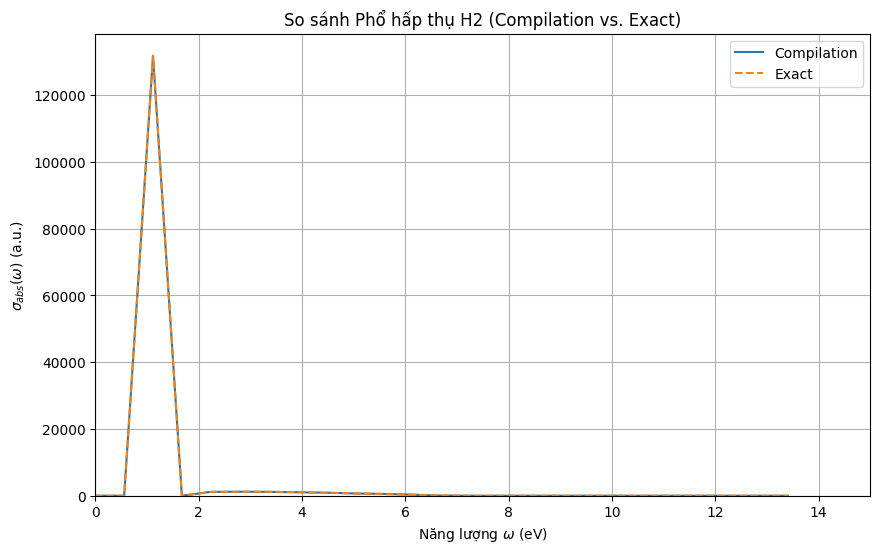

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import windows

# 1. Xác định các tham số chung
if len(times_plot_exact) < 2:
    print("Lỗi: Cần ít nhất 2 điểm thời gian để thực hiện FFT.")
else:
    dt_fourier = times_plot_exact[1] - times_plot_exact[0]
    N_points = len(times_plot_exact)

    # 2. Chuẩn bị các tín hiệu E(t) và d(t)
    window = windows.blackman(N_points)
    
    # Tín hiệu từ Pennylane
    d_z_t_pennylane_windowed = muz_plot_pennylane * window
    
    # Tín hiệu chính xác (exact)
    d_z_t_exact_windowed = muz_plot_exact * window

    # Tín hiệu trường điện từ (giống nhau cho cả hai trường hợp)
    def f_t_lorentz(t, E0, Gamma):
        return (E0 / np.pi) * Gamma / (Gamma**2 + t**2)
    times_plot_exact_np = np.array(times_plot_exact)
    E0 = 0.01
    Gamma = 0.25
    electric_field_z_t = f_t_lorentz(times_plot_exact_np, E0, Gamma)
    E_z_t_windowed = electric_field_z_t * window

    # 3. Thực hiện FFT
    d_z_omega_pennylane = fft(d_z_t_pennylane_windowed)
    d_z_omega_exact = fft(d_z_t_exact_windowed)
    E_z_omega_full = fft(E_z_t_windowed)

    # 4. Xử lý tần số và tính alpha, sigma cho cả hai trường hợp
    omega_fft_full = fftfreq(N_points, dt_fourier) * 2 * np.pi

    d_z_omega_pennylane_shifted = fftshift(d_z_omega_pennylane)
    d_z_omega_exact_shifted = fftshift(d_z_omega_exact)
    E_z_omega_shifted = fftshift(E_z_omega_full)
    omega_fft_shifted = fftshift(omega_fft_full)

    positive_freq_indices = omega_fft_shifted >= 0
    omega_positive = omega_fft_shifted[positive_freq_indices]
    
    # Hàm pomocniczy để tính sigma
    def calculate_sigma(d_z_omega_shifted, E_z_omega_shifted):
        d_z_omega_positive = d_z_omega_shifted[positive_freq_indices]
        E_z_omega_positive = E_z_omega_shifted[positive_freq_indices]
        alpha_zz_omega = np.zeros_like(d_z_omega_positive, dtype=complex)
        valid_E_indices = np.abs(E_z_omega_positive) > 1e-9
        alpha_zz_omega[valid_E_indices] = d_z_omega_positive[valid_E_indices] / E_z_omega_positive[valid_E_indices]
        c_au = 137.035999084
        sigma = (4 * np.pi * omega_positive / c_au) * np.imag(alpha_zz_omega)
        sigma[sigma < 0] = 0
        return sigma
    
    sigma_abs_pennylane = calculate_sigma(d_z_omega_pennylane_shifted, E_z_omega_shifted)
    sigma_abs_exact = calculate_sigma(d_z_omega_exact_shifted, E_z_omega_shifted)

    # 5. Chuyển đổi sang eV và vẽ đồ thị
    hartree_to_ev = 27.211386245988
    omega_ev = omega_positive * hartree_to_ev

    plt.figure(figsize=(10, 6))
    plt.plot(omega_ev, sigma_abs_pennylane, label='Compilation')
    plt.plot(omega_ev, sigma_abs_exact, label='Exact', linestyle='--')
    plt.xlabel("Năng lượng $\omega$ (eV)")
    plt.ylabel("$\\sigma_{abs}(\\omega)$ (a.u.)")
    plt.title("So sánh Phổ hấp thụ H2 (Compilation vs. Exact)")
    plt.legend()
    plt.grid(True)

    plt.xlim(0, 15) # Giới hạn trục x để dễ quan sát hơn
    plt.ylim(bottom=0)
    plt.show()

In [28]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import numpy as np
from qiskit.quantum_info import Operator
import matplotlib.pyplot as plt

# Hàm tính trường điện từ E(t)
E0_val = 0.01
Gamma_val = 0.25
def E_field(t):
    return (E0_val / np.pi) * Gamma_val / (Gamma_val**2 + t**2)

def run_trotter_simulation(total_time, num_steps, H_static, H_dynamic_op, E_func, initial_state, order=1):
    """Chạy mô phỏng tiến hóa thời gian bằng phương pháp Trotter.
    
    Args:
        total_time (float): Tổng thời gian mô phỏng.
        num_steps (int): Số bước Trotter.
        H_static (SparsePauliOp): Toán tử Hamiltonian tĩnh (H_0).
        H_dynamic_op (SparsePauliOp): Toán tử của phần động (ví dụ: z_dipole).
        E_func (function): Hàm trả về E(t).
        initial_state (array): Vector trạng thái ban đầu.
        order (int): Bậc của phương pháp Trotter (1 hoặc 2).
        
    Returns:
        array: Vector trạng thái cuối cùng.
    """
    num_qubits = H_static.num_qubits
    dt = total_time / num_steps
    
    # Tạo mạch và khởi tạo trạng thái ban đầu
    circuit = QuantumCircuit(num_qubits)
    circuit.initialize(initial_state, range(num_qubits))
    
    # Áp dụng các bước Trotter
    for i in range(num_steps):
        t = (i + 0.5) * dt # Lấy giá trị E(t) ở giữa bước thời gian
        E_t = E_func(t)
        
        if order == 1:
            # Trotter bậc 1: U(dt) ≈ exp(-i*H0*dt) * exp(-i*V(t)*dt)
            circuit.append(PauliEvolutionGate(H_static, time=dt), range(num_qubits))
            circuit.append(PauliEvolutionGate(H_dynamic_op, time=E_t * dt), range(num_qubits))
        elif order == 2:
            # Trotter bậc 2: U(dt) ≈ exp(-i*H0*dt/2) * exp(-i*V(t)*dt) * exp(-i*H0*dt/2)
            circuit.append(PauliEvolutionGate(H_static, time=dt/2), range(num_qubits))
            circuit.append(PauliEvolutionGate(H_dynamic_op, time=E_t * dt), range(num_qubits))
            circuit.append(PauliEvolutionGate(H_static, time=dt/2), range(num_qubits))
        else:
            raise ValueError("Bậc Trotter phải là 1 hoặc 2.")
            
    # Tính toán trạng thái cuối cùng
    final_state = Statevector(circuit)
    return final_state.data

# --- Ví dụ sử dụng và so sánh ---
# T_final = 10.0      # Thời gian mô phỏng tổng cộng
#= num_trotter_steps = 100 # Số bước Trotter

# Lấy các toán tử và trạng thái ban đầu từ các ô trước
H0_op = H_0 # Chính là qubit_jw_op
z_dipole_op = z_dipole_qubit
psi0_vec = psi_0_vqe
num_qubits = H0_op.num_qubits

# Chạy mô phỏng Trotter bậc 1
# psi_final_t1 = run_trotter_simulation(T_final, num_trotter_steps, H0_op, z_dipole_op, E_field, psi0_vec, order=1)

# # Chạy mô phỏng Trotter bậc 2
# psi_final_t2 = run_trotter_simulation(T_final, num_trotter_steps, H0_op, z_dipole_op, E_field, psi0_vec, order=2)

# Tính kết quả chính xác tại T_final để so sánh
# (Lưu ý: hàm time_dependent của bạn tính toán toán tử U, không phải trạng thái psi)
# U_exact_matrix = Operator(time_dependent(num_qubits, H_time, T_final)).data
# psi_exact_final_vec = U_exact_matrix @ psi0_vec.reshape(-1, 1)
# psi_exact_final_vec = psi_exact_final_vec.flatten()

# Tính toán độ trung thực (Fidelity)
# fidelity1 = np.abs(np.dot(psi_exact_final_vec.conj(), psi_final_t1))**2
# fidelity2 = np.abs(np.dot(psi_exact_final_vec.conj(), psi_final_t2))**2

# print(f"So sánh tại T = {T_final} với {num_trotter_steps} bước:")
# print(f"Fidelity (Bậc 1 vs. Chính xác): {fidelity1:.6f}")
# print(f"Fidelity (Bậc 2 vs. Chính xác): {fidelity2:.6f}")

# Bạn có thể tăng `num_trotter_steps` để thấy độ chính xác tăng lên.

In [ ]:
# --- Bước 1: Tính toán dipole moment theo thời gian bằng Trotter ---
# Sử dụng lại các biến đã định nghĩa từ các ô trước

times_for_trotter_plot = times
initial_state_vec = psi_0_vqe

muz_plot_trotter_t1 = []
muz_plot_trotter_t2 = []

# Cấu hình: số bước Trotter trên một đơn vị thời gian (a.u.)
# Tăng giá trị này để tăng độ chính xác (nhưng sẽ chạy chậm hơn)
steps_per_au = 10 

print("Bắt đầu mô phỏng Trotter để tính dipole moment...")

# Hàm tính giá trị kỳ vọng (đã có ở các ô trên)
def calculate_expectation_value(state_vector_flat, pauli_op_sparse):
    if pauli_op_sparse is None or state_vector_flat is None:
        return np.nan
    sv = Statevector(state_vector_flat)
    try:
        exp_val = sv.expectation_value(pauli_op_sparse)
        return exp_val.real 
    except Exception as e_exp:
        print(f"    Lỗi khi tính giá trị kỳ vọng: {e_exp}")
        return np.nan

for t in times_for_trotter_plot:
    # Với t=0, trạng thái chính là trạng thái ban đầu
    if t == 0:
        psi_t_t1 = initial_state_vec
        psi_t_t2 = initial_state_vec
    else:
        # Số bước trotter tỉ lệ với thời gian để đảm bảo độ chính xác
        num_steps = max(1, int(t * steps_per_au))
        psi_t_t1 = run_trotter_simulation(t, num_steps, H_0, z_dipole_qubit, E_field, initial_state_vec, order=1)
        psi_t_t2 = run_trotter_simulation(t, num_steps, H_0, z_dipole_qubit, E_field, initial_state_vec, order=2)

    # Tính giá trị kỳ vọng cho z-dipole
    muz_t1 = calculate_expectation_value(psi_t_t1, z_dipole_qubit)
    muz_t2 = calculate_expectation_value(psi_t_t2, z_dipole_qubit)
    
    muz_plot_trotter_t1.append(muz_t1)
    muz_plot_trotter_t2.append(muz_t2)

print("Hoàn thành mô phỏng Trotter.")

# --- Bước 2: Vẽ đồ thị so sánh tất cả các phương pháp ---

plt.figure(figsize=(12, 7))

# Dữ liệu từ các ô trước: Exact và VQA
#plt.plot(times_exact, muz_plot_exact, label="$\\mu_z(t)$ - Exact", marker='*', linestyle='--', color='black', zorder=5)
plt.plot(times_pennylane, muz_plot_pennylane, label="$\\mu_z(t)$ - VQA", marker='^', linestyle='-', color='red')

# Dữ liệu Trotter vừa tính
plt.plot(times_for_trotter_plot, muz_plot_trotter_t1, label="$\\mu_z(t)$ - Trotter 1st Order", linestyle=':', marker='.', color='blue')
plt.plot(times_for_trotter_plot, muz_plot_trotter_t2, label="$\\mu_z(t)$ - Trotter 2nd Order", linestyle='-.', marker='x', color='green')

plt.xlabel("Time (a.u.)")
plt.ylabel("Dipole moment (a.u.)")
plt.title("Time Evolution of Dipole Moment (Comparison)")
plt.legend()
plt.grid(True)
plt.show()


Bắt đầu mô phỏng Trotter để tính dipole moment...
Hoàn thành mô phỏng Trotter.


NameError: name 'times_exact' is not defined

<Figure size 1200x700 with 0 Axes>

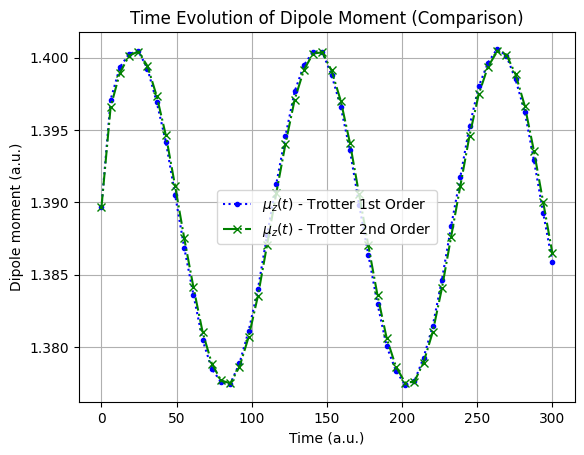

In [31]:

# Dữ liệu Trotter vừa tính
plt.plot(times_for_trotter_plot, muz_plot_trotter_t1, label="$\\mu_z(t)$ - Trotter 1st Order", linestyle=':', marker='.', color='blue')
plt.plot(times_for_trotter_plot, muz_plot_trotter_t2, label="$\\mu_z(t)$ - Trotter 2nd Order", linestyle='-.', marker='x', color='green')

plt.xlabel("Time (a.u.)")
plt.ylabel("Dipole moment (a.u.)")
plt.title("Time Evolution of Dipole Moment (Comparison)")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
import numpy as np
from scipy.linalg import expm 
from qiskit.quantum_info import Operator, Statevector 
import time

# --- Cấu hình và các hàm pomocniczy (giữ nguyên từ trước) ---
H_static_mat = H_0.to_matrix(sparse=False)
D_mat = z_dipole_matrix     
DIM = 2**num_qubits
Gamma = 0.25
E0 = 0.01

def f_lorentzian(t, E0, Gamma): 
    return (E0 / np.pi) * Gamma / (Gamma**2 + t**2)

def f_integral(t_start, t_end, E0, Gamma):
    return (E0/ np.pi) * (np.arctan(t_end / Gamma) - np.arctan(t_start / Gamma))

def trapezoidal_weights(n_points):
    if n_points <= 1: return np.array([1.0]) if n_points == 1 else np.array([])
    weights_val = np.ones(n_points)
    weights_val[0] = weights_val[-1] = 0.5
    return weights_val * (1.0 / (n_points - 1))

print("Tính toán trước [H0, D]...")
Comm_H0_D = H_static_mat @ D_mat -  D_mat @ H_static_mat

M_inner_integral = 50 # Số điểm tích phân cho mỗi bước Magnus

def compute_U_step_magnus2(t_j_start, h_step): 
    if h_step == 0:
        return np.eye(DIM, dtype=complex)
    
    Omega1 = -1j * (H_static_mat * h_step + D_mat * f_integral(t_j_start, t_j_start + h_step, E0, Gamma))
    
    Omega2 = np.zeros((DIM, DIM), dtype=complex)
    if M_inner_integral > 1:
        t_points_inner = np.linspace(t_j_start, t_j_start + h_step, M_inner_integral)
        delta_t_inner = h_step / (M_inner_integral - 1)
        weights_inner = trapezoidal_weights(M_inner_integral) * delta_t_inner
        f_values_inner = f_lorentzian(t_points_inner, E0, Gamma)

        for p in range(M_inner_integral):
            t1 = t_points_inner[p]
            f_t1 = f_values_inner[p]
            integral_f_t2_up_to_t1 = f_integral(t_j_start, t1, E0, Gamma)
            term_for_outer_integral = integral_f_t2_up_to_t1 - (f_t1 * (t1 - t_j_start))
            Omega2 += term_for_outer_integral * Comm_H0_D * weights_inner[p]
            
    Omega2 *= -0.5
    
    Omega = Omega1 + Omega2
    U_step = expm(Omega)
    return U_step

# --- Thuật toán mô phỏng mới với bước thời gian nhỏ ---
print("\\nBắt đầu mô phỏng Magnus bậc 2 với bước thời gian nhỏ...")
start_run_time = time.time()


# Các điểm thời gian chúng ta muốn LƯU kết quả
times = np.linspace(0,300,50)
times_plot = times # Sử dụng lại mảng times từ các ô trước

# Bước thời gian NHỎ dùng để tính toán Magnus
dt_magnus = 0.1 

# Điểm thời gian cuối cùng cần tính
T_final = times_plot[-1]

# Khởi tạo
current_t = 0.0
# Lưu trạng thái tại các thời điểm mong muốn
all_psi_t_magnus_map = {0.0: Statevector(psi_0_vqe)}
# Trạng thái hiện tại trong vòng lặp
psi_current_iter = Statevector(psi_0_vqe)
# Index cho mảng times_plot
plot_idx = 1 # Bắt đầu từ 1 vì t=0 đã có

while current_t < T_final and plot_idx < len(times_plot):
    # Tính bước nhảy h cho đến điểm cần vẽ đồ thị tiếp theo
    h = times_plot[plot_idx] - current_t
    
    # Chia bước h này thành nhiều bước dt_magnus nhỏ hơn
    num_sub_steps = max(1, int(np.ceil(h / dt_magnus)))
    dt_sub_step = h / num_sub_steps

    psi_at_h = psi_current_iter
    
    for i in range(num_sub_steps):
        t_sub_step_start = current_t + i * dt_sub_step
        U_sub_step = compute_U_step_magnus2(t_sub_step_start, dt_sub_step)
        psi_at_h = psi_at_h.evolve(Operator(U_sub_step))

    # Lưu kết quả tại điểm mong muốn
    all_psi_t_magnus_map[times_plot[plot_idx]] = psi_at_h
    
    # Cập nhật cho vòng lặp tiếp theo
    current_t = times_plot[plot_idx]
    psi_current_iter = psi_at_h
    plot_idx += 1
    
end_run_time = time.time()
print(f"Hoàn thành mô phỏng. Thời gian: {end_run_time - start_run_time:.2f} giây")


Tính toán trước [H0, D]...
\nBắt đầu mô phỏng Magnus bậc 2 với bước thời gian nhỏ...
Hoàn thành mô phỏng. Thời gian: 0.90 giây


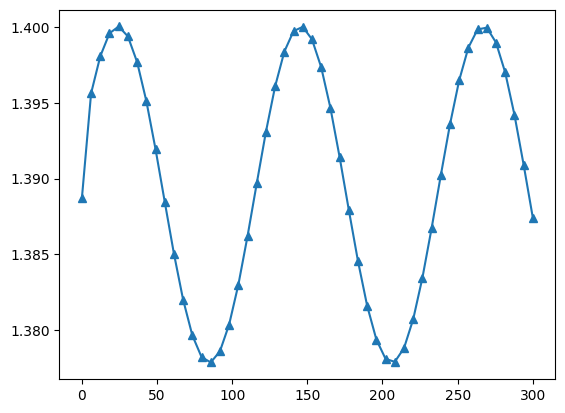

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp 
import qiskit 

def calculate_expectation_value(state_vector_flat, pauli_op_sparse):
    if pauli_op_sparse is None or state_vector_flat is None:
        return np.nan
    sv = Statevector(state_vector_flat)
    try:
        exp_val = sv.expectation_value(pauli_op_sparse)
        return exp_val.real 
    except Exception as e_exp:
        print(f"    Lỗi khi tính giá trị kỳ vọng: {e_exp}")
        return np.nan
    
times_plot_magnus2 = []
muz_plot_magnus2 = []


# Magnus2 

sorted_times_magnus = sorted(all_psi_t_magnus_map.keys())
for t_current in sorted_times_magnus:       
    psi_t_magnus_current = all_psi_t_magnus_map[t_current]
    
    if psi_t_magnus_current is not None:
        # print(f"  Tính toán cho t = {t_current:.4f} (Magnus2)") # Bỏ comment nếu cần debug
        times_plot_magnus2.append(t_current)
        muz_plot_magnus2.append(calculate_expectation_value(psi_t_magnus_current, z_dipole_qubit))
    else:
        times_plot_magnus2.append(t_current)
        muz_plot_magnus2.append(np.nan)

times_plot_np_magnus2 = np.array(times_plot_magnus2)
muz_plot_np_magnus2 = np.array(muz_plot_magnus2)

#Vẽ đường từ kết quả Magnus2
if muz_plot_np_magnus2.size > 0 and np.any(~np.isnan(muz_plot_np_magnus2)):
    plt.plot(times_plot_np_magnus2, muz_plot_np_magnus2, label="$\mu_z(t)$ - Magnus2", marker='^', linestyle='-')

 
# --- Tính toán giá trị kỳ vọng cho Magnus2 (nếu chưa có) ---
# Đảm bảo rằng all_psi_t_magnus_map đã được tính toán từ ô trước



   



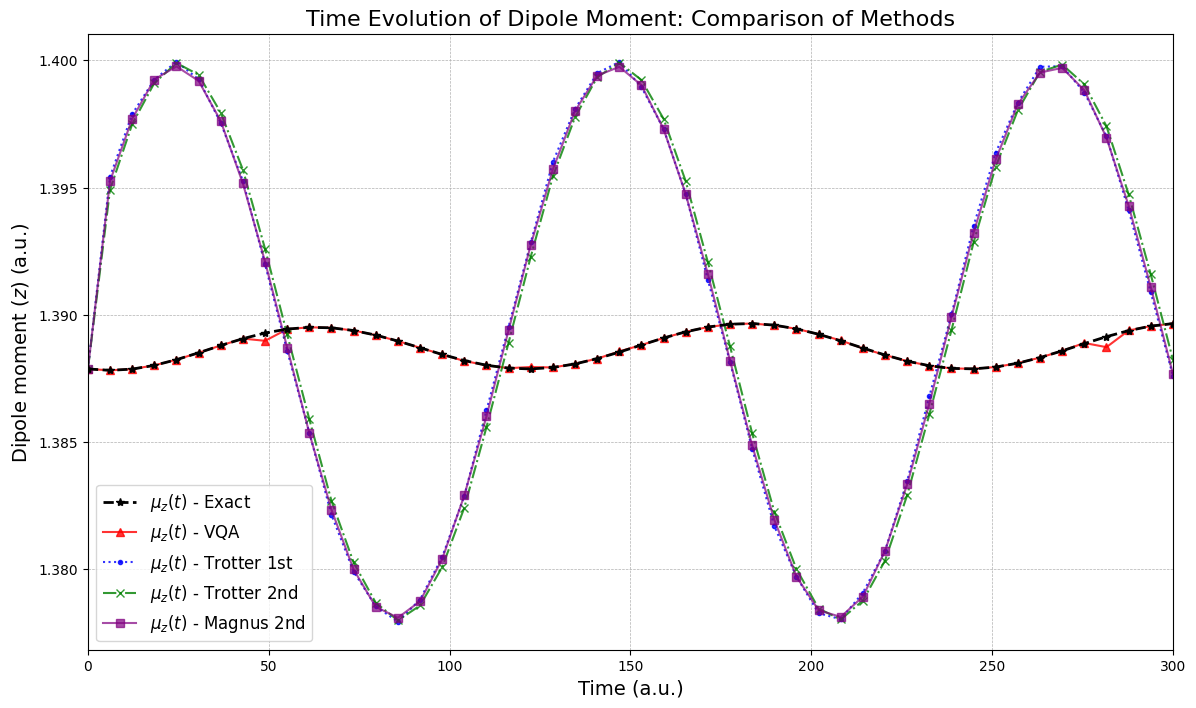

In [38]:
import matplotlib.pyplot as plt
import numpy as np

muz_plot_magnus2 = []
times_plot_magnus2 = sorted(all_psi_t_magnus_map.keys())

for t in times_plot_magnus2:
    psi_t_magnus_current = all_psi_t_magnus_map.get(t)
    if psi_t_magnus_current is not None:
        # Sử dụng lại hàm calculate_expectation_value đã định nghĩa
        muz_magnus = calculate_expectation_value(psi_t_magnus_current.data, z_dipole_qubit)
        muz_plot_magnus2.append(muz_magnus)
    else:
        muz_plot_magnus2.append(np.nan)

# --- Vẽ đồ thị so sánh tất cả các phương pháp ---

plt.figure(figsize=(14, 8))

# Dữ liệu từ các ô trước
# 1. Exact (làm đường tham chiếu)
plt.plot(times_exact, muz_plot_exact, label="$\\mu_z(t)$ - Exact", marker='*', linestyle='--', color='black', zorder=10, linewidth=2)

# 2. VQA (Train)
plt.plot(times_pennylane, muz_plot_pennylane, label="$\\mu_z(t)$ - VQA", marker='^', linestyle='-', color='red', alpha=0.8)

# 3. Trotter (đã tính toán ở ô eb0f77b1)
plt.plot(times_for_trotter_plot, muz_plot_trotter_t1, label="$\\mu_z(t)$ - Trotter 1st", linestyle=':', marker='.', color='blue', alpha=0.8)
plt.plot(times_for_trotter_plot, muz_plot_trotter_t2, label="$\\mu_z(t)$ - Trotter 2nd", linestyle='-.', marker='x', color='green', alpha=0.8)

# 4. Magnus2 (vừa tính ở trên)
plt.plot(times_plot_magnus2, muz_plot_magnus2, label="$\\mu_z(t)$ - Magnus 2nd", linestyle='-', marker='s', color='purple', alpha=0.7)


# --- Định dạng đồ thị ---
plt.xlabel("Time (a.u.)", fontsize=14)
plt.ylabel("Dipole moment ($z$) (a.u.)", fontsize=14)
plt.title("Time Evolution of Dipole Moment: Comparison of Methods", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(0, max(times_exact.max(), 100)) # Giới hạn trục x để dễ quan sát
plt.show()

In [9]:
# --- Hàm giải phương trình Schrödinger chính xác bằng ODE Solver ---
from scipy.integrate import solve_ivp
from qiskit.quantum_info import Statevector, Operator
import numpy as np
import time

# --- Hàm tính giá trị kỳ vọng (sửa để xử lý lỗi "not contiguous") ---
def calculate_expectation_value_robust(state_vector_flat, pauli_op_sparse):
    if pauli_op_sparse is None or state_vector_flat is None:
        return np.nan
    # Lỗi "not contiguous" xảy ra do cách Scipy lưu trữ dữ liệu.
    # np.ascontiguousarray() sẽ tạo một bản sao với bộ nhớ liền mạch.
    try:
        sv = Statevector(np.ascontiguousarray(state_vector_flat))
        exp_val = sv.expectation_value(pauli_op_sparse)
        return exp_val.real
    except Exception as e_exp:
        # Lỗi này không nên xảy ra nữa, nhưng vẫn để lại để debug
        print(f"    Lỗi khi tính giá trị kỳ vọng: {e_exp}")
        return np.nan

print("Bắt đầu chạy mô phỏng chính xác (ODE)...")
start_run_time = time.time()

# Lấy các ma trận cần thiết đã tính ở ô trên
H_static_mat_for_ode = H_0.to_matrix(sparse=False)
z_dipole_mat_for_ode = z_dipole_matrix

# Định nghĩa lại hàm E(t) để code dễ đọc
E0_val_for_ode = 0.01
Gamma_val_for_ode = 0.25
def E_field_for_ode(t):
    return (E0_val_for_ode / np.pi) * Gamma_val_for_ode / (Gamma_val_for_ode**2 + t**2)

# Đây là hàm f(t, y) trong dy/dt = f(t, y), với y là vector trạng thái psi
def schrodinger_rhs(t, psi_flat):
    H_t_mat = H_static_mat_for_ode + E_field_for_ode(t) * z_dipole_mat_for_ode
    return -1j * H_t_mat @ psi_flat

# Sử dụng lại các mảng `times` và `psi_0_vqe` từ các ô trước
times_for_ode_plot = times
initial_state_vec_for_ode = psi_0_vqe

# Dùng solve_ivp để giải
ode_solution = solve_ivp(
    schrodinger_rhs,
    t_span=[times_for_ode_plot[0], times_for_ode_plot[-1]],
    y0=initial_state_vec_for_ode,
    t_eval=times_for_ode_plot,
    rtol=1e-8,
    atol=1e-8
)

if ode_solution.success:
    print("Giải ODE thành công.")
    all_psi_t_exact_ode = ode_solution.y.T
else:
    print("Giải ODE thất bại:", ode_solution.message)
    all_psi_t_exact_ode = np.array([initial_state_vec_for_ode] * len(times_for_ode_plot))

# --- Tính giá trị kỳ vọng dipole moment từ kết quả chính xác này ---
muz_plot_exact_ode = []
for psi_t in all_psi_t_exact_ode:
    # Sử dụng hàm đã được sửa lỗi
    exp_val = calculate_expectation_value_robust(psi_t, z_dipole_qubit)
    muz_plot_exact_ode.append(exp_val)

end_run_time = time.time()
print(f"Đã tính xong dipole moment từ kết quả ODE. Thời gian: {end_run_time - start_run_time:.2f} giây")

Bắt đầu chạy mô phỏng chính xác (ODE)...
Giải ODE thành công.
Đã tính xong dipole moment từ kết quả ODE. Thời gian: 0.18 giây


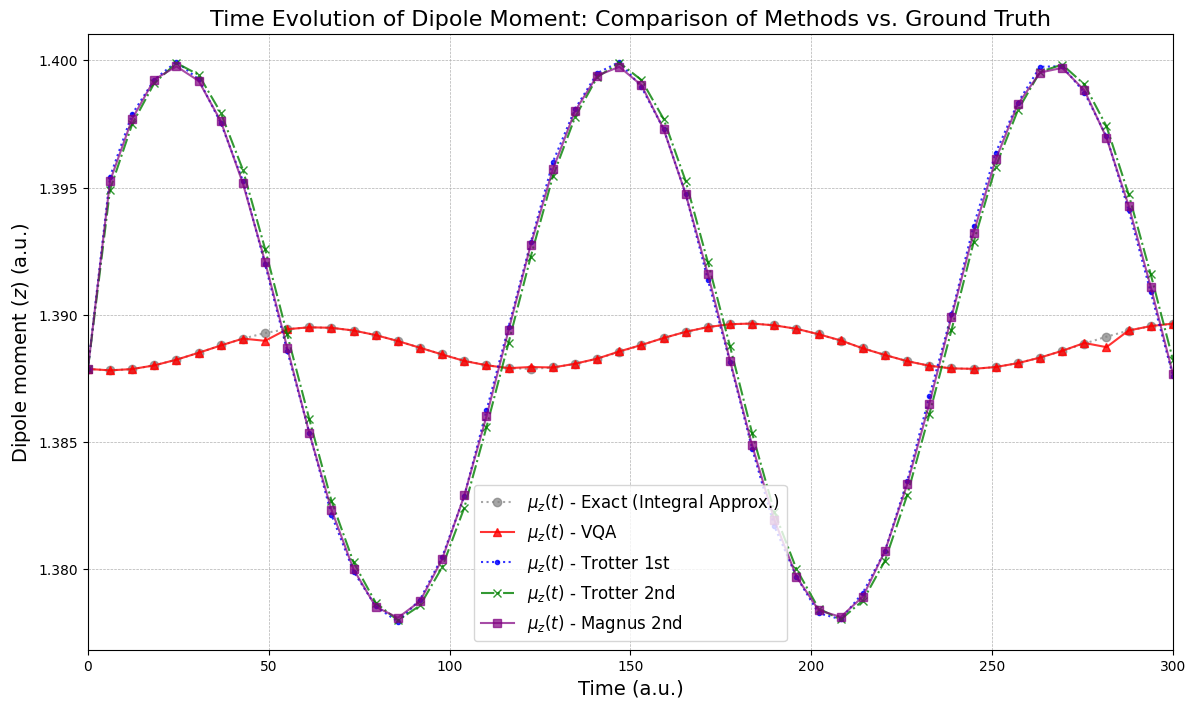

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# --- Vẽ đồ thị so sánh TẤT CẢ các phương pháp ---
# Đồ thị này sẽ so sánh:
# 1. Exact (cũ - tích phân)
# 2. VQA (Train)
# 3. Trotter 1 & 2
# 4. Magnus 2
# 5. Exact MỚI (ODE Solver - Ground Truth)

plt.figure(figsize=(14, 8))

# Dữ liệu từ các ô trước
plt.plot(times_exact, muz_plot_exact, label="$\\mu_z(t)$ - Exact (Integral Approx.)", marker='o', linestyle=':', color='gray', alpha=0.7)
plt.plot(times_pennylane, muz_plot_pennylane, label="$\\mu_z(t)$ - VQA", marker='^', linestyle='-', color='red', alpha=0.8)
plt.plot(times_for_trotter_plot, muz_plot_trotter_t1, label="$\\mu_z(t)$ - Trotter 1st", linestyle=':', marker='.', color='blue', alpha=0.8)
plt.plot(times_for_trotter_plot, muz_plot_trotter_t2, label="$\\mu_z(t)$ - Trotter 2nd", linestyle='-.', marker='x', color='green', alpha=0.8)
plt.plot(times_plot_magnus2, muz_plot_magnus2, label="$\\mu_z(t)$ - Magnus 2nd", linestyle='-', marker='s', color='purple', alpha=0.7)

# Dữ liệu "Ground Truth" mới tính từ ODE
# Dùng zorder để đảm bảo đường này nổi bật nhất
#plt.plot(times_for_ode_plot, muz_plot_exact_ode, label="$\\mu_z(t)$ - Exact (ODE Ground Truth)", linestyle='--', color='black', zorder=10, linewidth=2.5)


# --- Định dạng đồ thị ---
plt.xlabel("Time (a.u.)", fontsize=14)
plt.ylabel("Dipole moment ($z$) (a.u.)", fontsize=14)
plt.title("Time Evolution of Dipole Moment: Comparison of Methods vs. Ground Truth", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(0, max(times_exact.max(), 100)) # Giới hạn trục x để dễ quan sát
plt.show()

In [10]:

import numpy as np
from scipy.integrate import solve_ivp
import time

# --- Định nghĩa lại các thành phần cần thiết ---
H0_matrix = H_0.to_matrix()
Dz_matrix = z_dipole_qubit.to_matrix()
dim = H0_matrix.shape[0]
U0_flat = np.eye(dim, dtype=complex).flatten() # U(0) = I, làm phẳng cho solver

# Hàm E-field
E0_val = 0.01
Gamma_val = 0.25
def E_field(t):
    if t < -200 or t > 200: return 0.0
    return (E0_val / np.pi) * Gamma_val / (Gamma_val**2 + t**2)

# Hàm H(t)
def H_t_matrix(t):
    return H0_matrix + E_field(t) * Dz_matrix

# --- Định nghĩa vế phải của PT vi phân cho Unitary: dU/dt = -i * H(t) * U ---
def unitary_rhs(t, U_flat):
    U = U_flat.reshape(dim, dim) # Chuyển vector về ma trận
    H = H_t_matrix(t)
    dU_dt = -1j * (H @ U)
    return dU_dt.flatten() # Chuyển về vector cho solver

# --- Thiết lập thời gian và chạy solver ---
# Dùng các điểm thời gian này để huấn luyện
times_for_training = np.linspace(0, 300, 50) 
t_span = [times_for_training[0], times_for_training[-1]]

print("Bắt đầu tính toán Target Unitaries bằng ODE Solver...")
start_time = time.time()
sol_U = solve_ivp(
    unitary_rhs,
    t_span,
    U0_flat,
    t_eval=times_for_training,
    method='RK45', # Phương pháp Runge-Kutta bậc 4(5)
    rtol=1e-8, # Dung sai cao để có kết quả chính xác
    atol=1e-8
)
end_time = time.time()
print(f"Hoàn thành trong {end_time - start_time:.2f} giây.")

# --- Xử lý kết quả ---
target_unitaries_list = []
if sol_U.success:
    # sol_U.y có dạng (dim*dim, N_points)
    unitaries_flat = sol_U.y.T # Chuyển vị thành (N_points, dim*dim)
    for u_flat in unitaries_flat:
        target_unitaries_list.append(u_flat.reshape(dim, dim))
    print(f"Đã tạo thành công {len(target_unitaries_list)} target unitaries.")
else:
    print("Lỗi: Bộ giải ODE không hội tụ khi tính toán Unitary.")


Bắt đầu tính toán Target Unitaries bằng ODE Solver...
Hoàn thành trong 0.20 giây.
Đã tạo thành công 50 target unitaries.


In [11]:

import math
from qiskit.quantum_info import Operator, Statevector
import pennylane as qml
from numpy.random import Generator, PCG64
import numpy as np
import pennylane.numpy as pnp
import matplotlib.pyplot as plt

# --- Các thành phần của VQA (giữ nguyên) ---
num_qubits = H_0.num_qubits
num_layers = 6 
pauli_labels = combined_unique_labels
num_thetas = len(pauli_labels) * num_layers
rng = Generator(PCG64())  

times = np.linspace(0,300,50)

all_optimized_U_theta_t_new = {}
all_psi_t_pennylane_new = {}
#all_costs_history_per_t = {}
all_final_norms = []
# --- Vòng lặp huấn luyện với Target mới ---
times = times_for_training
# Khởi tạo tham số ngẫu nhiên nhỏ
thetas = pnp.array(2*math.pi*rng.random(size = num_thetas), requires_grad=True)

print("Bắt đầu mô phỏng tiến hóa thời gian bằng Pennylane")
for i, t in enumerate(times):
    target = target_unitaries_list[i]
    print(f"\n--- Thời điểm t = {t:.4f} ---")

    #target = time_dependent(num_qubits, H_time, t)
    
    def cost(thetas): 
        ansatz_matrix = qml.matrix(pennylane_ansatz_from_qiskit_pauli_evo,
                                   wire_order=list(range(num_qubits)) 
                                  )(
                                      thetas,
                                      num_qubits,
                                      pauli_labels,
                                      num_layers
                                  )
        return cost_func.c_hst(ansatz_matrix, target)

    opt = qml.AdamOptimizer(stepsize=0.01)
    steps = 300
    costs = []
    muz_plot_pennylane_new = []


    for n in range(steps):
        thetas, prev_cost = opt.step_and_cost(cost, thetas)
        if (n + 1) % (steps // 2 if steps >=2 else 1) == 0: 
            print(f"    t={t:.2f}, Opt. step {n+1}/{steps}, Cost: {prev_cost:.6f}")
        if prev_cost < constant.error:
                print(f"    Đạt ngưỡng lỗi ở bước {n+1} cho t={t:.2f}")
               # break
        costs.append(prev_cost)

    U_theta_t = None
    if num_thetas > 0:
        U_theta_t = qml.matrix(pennylane_ansatz_from_qiskit_pauli_evo,
                                            wire_order=range(num_qubits) #if num_qubits > 0 else [0]
                                           )(
                                               thetas, 
                                               num_qubits,
                                               pauli_labels,
                                               num_layers
                                           )


    all_optimized_U_theta_t_new[t] = U_theta_t.numpy() if hasattr(U_theta_t, 'numpy') else np.asarray(U_theta_t)

    norm_diff = np.linalg.norm(U_theta_t - target, 'fro')
    all_final_norms.append(norm_diff)
    # Công thức: F(A, B) = sqrt(Tr((A-B)^H * (A-B)))
    # diff_dm = dm_exact - dm_approx
    #frobenius_dist = qml.math.norm(diff_dm, ord='fro')
    # frobenius_dist = qml.math.sqrt(qml.math.real(qml.math.trace(qml.math.dot(qml.math.conj(qml.math.transpose(diff_dm)), diff_dm))))
    # all_frobenius_distances[t] = frobenius_dist

    print(f"  Frobenius Norm ||U(θ*) - V(t)|| = {norm_diff:.6e}")

    if num_qubits >= 0 : 
        psi_0_col = psi_0_vqe.reshape(-1, 1)
        U_mat_np_for_psi = all_optimized_U_theta_t_new[t]       

        psi_t_col_approx = U_mat_np_for_psi @ psi_0_col
        psi_t_approx = psi_t_col_approx.flatten()
        all_psi_t_pennylane_new[t] = psi_t_approx



Bắt đầu mô phỏng tiến hóa thời gian bằng Pennylane

--- Thời điểm t = 0.0000 ---
    Đạt ngưỡng lỗi ở bước 99 cho t=0.00
    Đạt ngưỡng lỗi ở bước 100 cho t=0.00
    Đạt ngưỡng lỗi ở bước 101 cho t=0.00
    Đạt ngưỡng lỗi ở bước 102 cho t=0.00
    Đạt ngưỡng lỗi ở bước 103 cho t=0.00
    Đạt ngưỡng lỗi ở bước 104 cho t=0.00
    Đạt ngưỡng lỗi ở bước 105 cho t=0.00
    Đạt ngưỡng lỗi ở bước 106 cho t=0.00
    Đạt ngưỡng lỗi ở bước 107 cho t=0.00
    Đạt ngưỡng lỗi ở bước 108 cho t=0.00
    Đạt ngưỡng lỗi ở bước 109 cho t=0.00
    Đạt ngưỡng lỗi ở bước 110 cho t=0.00
    Đạt ngưỡng lỗi ở bước 111 cho t=0.00
    Đạt ngưỡng lỗi ở bước 112 cho t=0.00
    Đạt ngưỡng lỗi ở bước 113 cho t=0.00
    Đạt ngưỡng lỗi ở bước 114 cho t=0.00
    Đạt ngưỡng lỗi ở bước 115 cho t=0.00
    Đạt ngưỡng lỗi ở bước 116 cho t=0.00
    Đạt ngưỡng lỗi ở bước 117 cho t=0.00
    Đạt ngưỡng lỗi ở bước 118 cho t=0.00
    Đạt ngưỡng lỗi ở bước 119 cho t=0.00
    Đạt ngưỡng lỗi ở bước 120 cho t=0.00
    Đạt ngưỡng lỗi

In [30]:
print(costs[-1])

6.946542152608259e-06


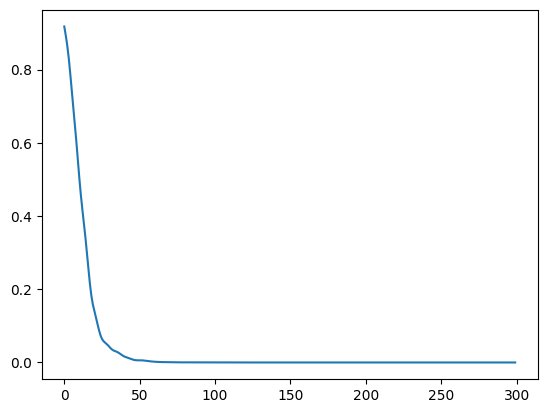

In [26]:
import matplotlib.pyplot as plt
plt.plot(costs)

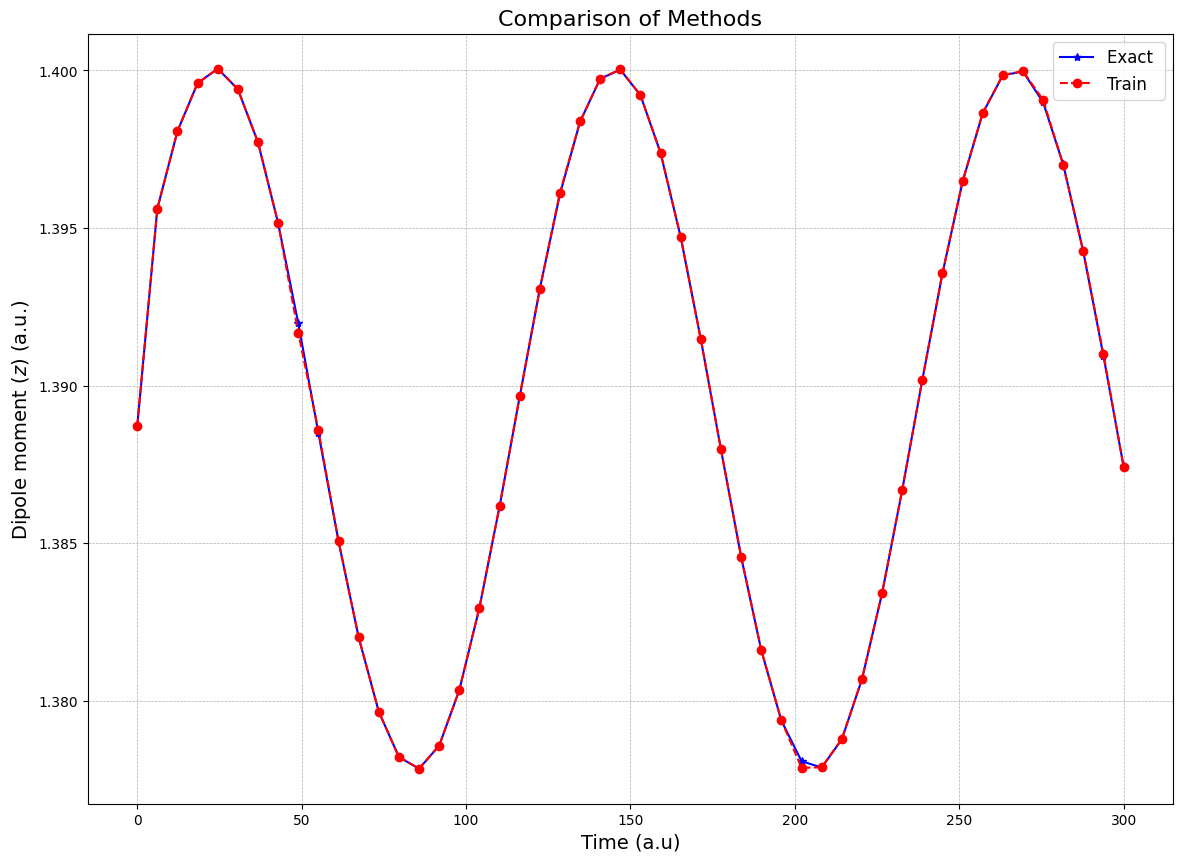

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# --- Bước 1: Tính toán giá trị kỳ vọng từ kết quả VQA mới ---

# Lấy các biến từ ô huấn luyện VQA mới (id: ee90b4ad)
# Đảm bảo ô đó đã được chạy
times_plot_pennylane_new = sorted(all_psi_t_pennylane_new.keys())
muz_plot_pennylane_new = []

for t in times_plot_pennylane_new:
    psi_t_current = all_psi_t_pennylane_new.get(t)
    if psi_t_current is not None:
        # Sử dụng lại ma trận Dz_matrix đã định nghĩa ở các ô trước
        exp_val = np.real(psi_t_current.conj().T @ Dz_matrix @ psi_t_current)
        muz_plot_pennylane_new.append(exp_val)

# --- Bước 2: Vẽ đồ thị so sánh TẤT CẢ các phương pháp ---
plt.figure(figsize=(14, 10))

# Dữ liệu "Ground Truth" mới tính từ ODE
if 'muz_plot_exact_ode' in locals() or 'muz_plot_exact_ode' in globals():
    plt.plot(times_for_training, muz_plot_exact_ode, label="Exact ", color='blue',marker='*', linestyle='-')

# Kết quả VQA mới (huấn luyện trên target chuẩn)
if muz_plot_pennylane_new:
    plt.plot(times_plot_pennylane_new, muz_plot_pennylane_new, label="Train", linestyle='--', marker='o', color='red', markersize=6)
    
# Kết quả VQA cũ (huấn luyện trên target xấp xỉ)
# if 'muz_plot_pennylane' in locals() or 'muz_plot_pennylane' in globals():
#     plt.plot(times_pennylane, muz_plot_pennylane, label="VQA (Trained on Integral Approx.)", marker='^', linestyle=':', color='orange', alpha=0.8)

# Các phương pháp xấp xỉ khác
if 'muz_plot_trotter_t2' in locals() or 'muz_plot_trotter_t2' in globals():
    plt.plot(times_for_trotter_plot, muz_plot_trotter_t2, label="Trotter 2nd", linestyle='-.',marker ='x', color='green', alpha=1)
# if 'muz_plot_magnus2' in locals() or 'muz_plot_magnus2' in globals():
#     plt.plot(times_plot_magnus2, muz_plot_np_magnus2, label="Magnus 2nd", linestyle='--',marker ='^', color='purple', alpha=1)
if 'muz_plot_trotter_t1' in locals() or 'muz_plot_trotter_t1' in globals():
    plt.plot(times_for_trotter_plot, muz_plot_trotter_t1, label="Trotter 1st", linestyle=':', marker='*', color='yellow', alpha=1)


# --- Định dạng đồ thị ---
plt.xlabel("Time (a.u)", fontsize=14)
plt.ylabel("Dipole moment ($z$) (a.u.)", fontsize=14)
plt.title("Comparison of Methods", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


In [17]:
# CELL MỚI: XUẤT GIÁ TRỊ TỪ LIST 'COSTS' RA FILE

import numpy as np

output_filename = "last_run_cost_history.txt"

try:
    # --- Bước 1: Kiểm tra sự tồn tại của biến 'costs' ---
    if 'costs' not in locals():
        raise NameError("Không tìm thấy biến 'costs'. Vui lòng chạy lại một ô code có quá trình tối ưu hóa để tạo ra biến này.")

    # --- Bước 2: Trích xuất giá trị số (float) từ mỗi tensor ---
    # Dùng list comprehension để tạo một list mới chỉ chứa các con số
    numeric_costs = [float(c) for c in costs]
    
    print(f"Đã trích xuất thành công {len(numeric_costs)} giá trị cost từ lần chạy cuối.")

    # --- Bước 3: Ghi kết quả ra file ---
    print(f"Đang ghi kết quả ra file '{output_filename}'...")
    
    with open(output_filename, "w") as f:
        # Ghi dòng tiêu đề cho các cột
        f.write("# Optimization_Step   Cost_Value\n")
        
        # Lặp qua dữ liệu và ghi ra file
        for step, cost_value in enumerate(numeric_costs):
            # step + 1 để bắt đầu từ bước 1
            f.write(f"{step + 1:<20} {cost_value:<.12f}\n")
            
    print(f"\nHoàn tất! Đã lưu thành công lịch sử cost vào file '{output_filename}'.")

except Exception as e:
    print(f"Đã xảy ra lỗi không mong muốn: {e}")

Đã trích xuất thành công 300 giá trị cost từ lần chạy cuối.
Đang ghi kết quả ra file 'last_run_cost_history.txt'...

Hoàn tất! Đã lưu thành công lịch sử cost vào file 'last_run_cost_history.txt'.


In [ ]:
# CELL HUẤN LUYỆN VQA (ĐÃ SỬA LỖI ĐỂ LƯU COST HISTORY)

import math
from qiskit.quantum_info import Operator, Statevector
import pennylane as qml
from numpy.random import Generator, PCG64
import numpy as np
import pennylane.numpy as pnp
import matplotlib.pyplot as plt

# --- Các thành phần của VQA (giả định đã có) ---
# num_qubits, num_layers, pauli_labels, times_for_training, target_unitaries_list, 
# pennylane_ansatz_from_qiskit_pauli_evo, cost_func, constant.error, psi_0_vqe

# --- Khởi tạo ---
rng = Generator(PCG64())
num_thetas = len(pauli_labels) * num_layers
thetas = pnp.array(2 * math.pi * rng.random(size=num_thetas), requires_grad=True)

# *** THAY ĐỔI QUAN TRỌNG: Tạo dictionary để lưu toàn bộ lịch sử cost ***
all_costs_history_per_t = {} 
all_psi_t_pennylane_new = {}
all_final_norms = []

print("Bắt đầu mô phỏng tiến hóa thời gian bằng Pennylane (có lưu cost history)")

# --- Vòng lặp huấn luyện chính ---
for i, t in enumerate(times_for_training):
    target = target_unitaries_list[i]
    print(f"\n--- Thời điểm t = {t:.4f} ---")

    def cost(thetas_local): 
        ansatz_matrix = qml.matrix(pennylane_ansatz_from_qiskit_pauli_evo,
                                   wire_order=list(range(num_qubits)) 
                                  )(thetas_local, pauli_labels, num_qubits, num_layers)
        # Frobenius norm của hiệu hai ma trận là hàm chi phí
        return np.linalg.norm(ansatz_matrix - target, 'fro')

    opt = qml.AdamOptimizer(stepsize=0.01)
    steps = 300
    
    # List này sẽ lưu cost cho CHỈ RIÊNG thời điểm t hiện tại
    cost_history_for_this_t = []

    for n in range(steps):
        thetas, prev_cost = opt.step_and_cost(cost, thetas)
        if (n + 1) % 100 == 0: 
            print(f"    t={t:.2f}, Opt. step {n+1}/{steps}, Cost: {prev_cost:.6f}")
        
        # Thêm cost của bước này vào list tạm thời
        cost_history_for_this_t.append(prev_cost)

    # *** THAY ĐỔI QUAN TRỌNG: Lưu list cost tạm thời vào dictionary chung ***
    all_costs_history_per_t[t] = cost_history_for_this_t

    # --- Tính toán và lưu các giá trị khác ---
    U_theta_t = qml.matrix(pennylane_ansatz_from_qiskit_pauli_evo,
                           wire_order=range(num_qubits)
                          )(thetas, pauli_labels, num_qubits, num_layers)

    norm_diff = np.linalg.norm(U_theta_t - target, 'fro')
    all_final_norms.append(norm_diff)
    print(f"  Frobenius Norm ||U(θ*) - V(t)|| = {norm_diff:.6e}")
    
    psi_t_approx = (U_theta_t @ psi_0_vqe).flatten()
    all_psi_t_pennylane_new[t] = psi_t_approx

print("\nHoàn tất quá trình huấn luyện.")

In [350]:
# CELL MỚI: XUẤT FILE COST HISTORY (SAU KHI ĐÃ SỬA Ô HUẤN LUYỆN)

import numpy as np

output_filename = "cost_history_train.txt"

try:
    # Sử dụng đúng tên biến là `all_costs_history_per_t`
    if 'all_costs_history_per_t' not in locals() or not isinstance(all_costs_history_per_t, dict):
        raise NameError("Biến `all_costs_history_per_t` chưa được định nghĩa. Vui lòng chạy lại ô huấn luyện đã được sửa lỗi.")

    print("Đã tìm thấy biến `all_costs_history_per_t`. Bắt đầu xuất file...")
    
    with open(output_filename, "w") as f:
        f.write("# Mỗi dòng tương ứng với một điểm thời gian huấn luyện.\n")
        f.write("# Cột đầu tiên là Thời gian (a.u.), các cột sau là lịch sử cost.\n")
        f.write("# ----------------------------------------------------------------\n")
        
        sorted_times = sorted(all_costs_history_per_t.keys())
        
        for t in sorted_times:
            cost_history_list = all_costs_history_per_t[t]
            costs_str = " ".join(f"{float(cost):<.8f}" for cost in cost_history_list)
            f.write(f"{t:<15.8f} {costs_str}\n")
            
    print(f"\nHoàn tất! Đã lưu thành công lịch sử cost vào file '{output_filename}'.")

except Exception as e:
    print(f"Đã xảy ra lỗi không mong muốn: {e}")

Đã xảy ra lỗi không mong muốn: Biến `all_costs_history_per_t` chưa được định nghĩa. Vui lòng chạy lại ô huấn luyện đã được sửa lỗi.


In [78]:
# CELL MỚI: CHUYỂN ĐỔI COST SANG LIST VÀ LƯU RA FILE

import numpy as np

output_filename = "cost_history_train.txt"

try:
    # --- Bước 1: Kiểm tra sự tồn tại của biến `costs_over_time` ---
    if 'costs' not in locals() or not isinstance(costs, dict):
        raise NameError("Biến `costs` (dạng dictionary) chưa được định nghĩa. Vui lòng chạy lại ô huấn luyện VQA trước.")

    # --- Bước 2: Chuyển đổi từ Dictionary sang List ---
    print("Đang chuyển đổi dictionary `costs_over_time` sang list...")
    
    # Tạo một list chứa các điểm thời gian, đã được sắp xếp
    times_list = sorted(costs.keys())
    
    # Tạo một list chứa các list lịch sử cost, theo đúng thứ tự của `times_list`
    costs_list = [costs[t] for t in times_list]
    
    print("Chuyển đổi hoàn tất.")

    # --- Bước 3: Ghi các list đã chuyển đổi ra file ---
    print(f"Đang ghi kết quả từ list ra file '{output_filename}'...")
    
    with open(output_filename, "w") as f:
        # Ghi dòng tiêu đề
        f.write("# Mỗi dòng tương ứng với một điểm thời gian huấn luyện.\n")
        f.write("# Cột đầu tiên là Thời gian (a.u.), các cột sau là lịch sử cost tại thời điểm đó.\n")
        f.write("# --------------------------------------------------------------------------\n")
        
        # Lặp qua các list bằng chỉ số (index)
        for i in range(len(times_list)):
            time_point = times_list[i]
            cost_history_at_time = costs_list[i]
            
            # Trích xuất giá trị số (float) từ mỗi tensor và tạo thành một chuỗi
            costs_str = " ".join(f"{float(cost):<.8f}" for cost in cost_history_at_time)
            
            # Ghi dòng dữ liệu ra file
            f.write(f"{time_point:<15.8f} {costs_str}\n")
            
    print(f"\nHoàn tất! Đã lưu thành công lịch sử cost vào file '{output_filename}'.")

except Exception as e:
    print(f"Đã xảy ra lỗi không mong muốn: {e}")


Đã xảy ra lỗi không mong muốn: Biến `costs` (dạng dictionary) chưa được định nghĩa. Vui lòng chạy lại ô huấn luyện VQA trước.


In [351]:
# CELL MỚI: LƯU KẾT QUẢ DIPOLE RA FILE TXT

import numpy as np

# Giả định rằng các biến này đã được tính toán ở các ô trước:
# - times_for_training: Mảng thời gian
# - muz_plot_exact_ode: Dữ liệu dipole từ ODE Solver (Exact)
# - muz_plot_pennylane_new: Dữ liệu dipole từ VQA đã được huấn luyện (Train)

output_filename = "dipole_results_new.txt"

try:
    with open(output_filename, "w") as f:
        # Ghi dòng tiêu đề cho các cột
        f.write("# Time (fs)   Dipole_Exact (a.u.)   Dipole_Magnus2 (a.u.)   Dipole_Trotter1 (a.u.)   Dipole_Trotter2 (a.u.)   Dipole_Train (a.u.)  \n")
        
        # Lặp qua từng điểm thời gian và ghi dữ liệu
        for i in range(len(times_for_training)):
            time_val = times_for_training[i]
            dipole_exact = muz_plot_exact_ode[i]
            dipole_magnus2 = muz_plot_magnus2[i]
            dipole_trotter1 = muz_plot_trotter_t1[i]
            dipole_trotter2 = muz_plot_trotter_t2[i]
            dipole_train = muz_plot_pennylane_new[i]
            
            # Định dạng và ghi một dòng dữ liệu
            f.write(f"{time_val:<15.6f} {dipole_exact:<21.12f} {dipole_magnus2:<21.12f} {dipole_trotter1:<21.12f} {dipole_trotter2:<21.12f} {dipole_train:<21.12f}\n")
            
    print(f"Đã lưu kết quả thành công vào file: {output_filename}")

except NameError:
    print("Lỗi: Không tìm thấy các biến cần thiết (times_for_training, muz_plot_exact_ode, muz_plot_pennylane_new).")
    print("Vui lòng đảm bảo bạn đã chạy các ô code tính toán và vẽ đồ thị trước khi chạy ô này.")


Đã lưu kết quả thành công vào file: dipole_results_new.txt


In [23]:
if frobenius_norms_over_time:
    sorted_times_for_plot = sorted(frobenius_norms_over_time.keys())
    norm_values_for_plot = [frobenius_norms_over_time[t] for t in sorted_times_for_plot]
    
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_times_for_plot, norm_values_for_plot, marker='o', linestyle='-', label='Frobenius Norm ')
    
    plt.xlabel("t")
    plt.ylabel("Frobenius Norm ||U(θ) - V(t)||")
    plt.title("Difference in Frobenius Norm over Time")
    plt.grid(True)
    plt.show()
else:
    print("Không có dữ liệu Frobenius norm để vẽ đồ thị.")

NameError: name 'frobenius_norms_over_time' is not defined

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import windows

# 1. Xác định các tham số chung
if len(times_plot_pennylane_new) < 2:
    print("Lỗi: Cần ít nhất 2 điểm thời gian để thực hiện FFT.")
else:
    dt_fourier = times_plot_pennylane_new[1] - times_plot_pennylane_new[0]
    N_points = len(times_plot_pennylane_new)

    damping_rate = 0.001
    damping_factor = np.exp(-damping_rate * times_plot_exact_np)

    # 2. Chuẩn bị các tín hiệu E(t) và d(t)
    window = windows.blackman(N_points)
    
    # Tín hiệu từ Pennylane
    d_z_t_pennylane_windowed = muz_plot_pennylane_new * window*damping_factor
    d_z_t_trotter1_windowed = muz_plot_trotter_t1 * window*damping_factor
    d_z_t_exact_windowed = muz_plot_exact_ode * window*damping_factor

   

    # Tín hiệu trường điện từ (giống nhau cho cả hai trường hợp)
    def f_t_lorentz(t, E0, Gamma):
        return (E0 / np.pi) * Gamma / (Gamma**2 + t**2)
    
    times_plot_exact_np = np.array(times_plot_pennylane_new)
    E0 = 0.01
    Gamma = 0.25
    electric_field_z_t = f_t_lorentz(times_plot_exact_np, E0, Gamma)
    E_z_t_windowed = electric_field_z_t * window

    # 3. Thực hiện FFT
    d_z_omega_pennylane = fft(d_z_t_pennylane_windowed)
    d_z_omega_trotter1 = fft(d_z_t_trotter1_windowed)
    d_z_omega_exact = fft(d_z_t_exact_windowed)
    E_z_omega_full = fft(E_z_t_windowed)

    # 4. Xử lý tần số và tính alpha, sigma cho cả hai trường hợp
    omega_fft_full = fftfreq(N_points, dt_fourier) * 2 * np.pi
    d_z_omega_trotter1_shifted = fftshift(d_z_omega_trotter1)
    d_z_omega_pennylane_shifted = fftshift(d_z_omega_pennylane)
    d_z_omega_exact_shifted = fftshift(d_z_omega_exact)
    E_z_omega_shifted = fftshift(E_z_omega_full)
    omega_fft_shifted = fftshift(omega_fft_full)

    positive_freq_indices = omega_fft_shifted >= 0
    omega_positive = omega_fft_shifted[positive_freq_indices]
    
    # Hàm pomocniczy để tính sigma
    def calculate_sigma(d_z_omega_shifted, E_z_omega_shifted):
        d_z_omega_positive = d_z_omega_shifted[positive_freq_indices]
        E_z_omega_positive = E_z_omega_shifted[positive_freq_indices]
        alpha_zz_omega = np.zeros_like(d_z_omega_positive, dtype=complex)
        valid_E_indices = np.abs(E_z_omega_positive) > 1e-9
        alpha_zz_omega[valid_E_indices] = d_z_omega_positive[valid_E_indices] / E_z_omega_positive[valid_E_indices]
        c_au = 137.035999084
        sigma = (4 * np.pi * omega_positive / c_au) * np.imag(alpha_zz_omega)
        sigma[sigma < 0] = 0
        return sigma
    
    sigma_abs_pennylane = calculate_sigma(d_z_omega_pennylane_shifted, E_z_omega_shifted)
    sigma_abs_exact = calculate_sigma(d_z_omega_exact_shifted, E_z_omega_shifted)
    sigma_abs_trotter1 = calculate_sigma(d_z_omega_trotter1_shifted, E_z_omega_shifted)

    # 5. Chuyển đổi sang eV và vẽ đồ thị
    hartree_to_ev = 27.211386245988
    omega_ev = omega_positive * hartree_to_ev

    plt.figure(figsize=(10, 6))
    plt.plot(omega_ev, sigma_abs_pennylane, label='Compilation')
    plt.plot(omega_ev, sigma_abs_trotter1, label='Trotter 1st')
    plt.plot(omega_ev, sigma_abs_exact, label='Exact', linestyle='--')
    plt.xlabel("Năng lượng $\omega$ (eV)")
    plt.ylabel("$\\sigma_{abs}(\\omega)$ (a.u.)")
    plt.title("So sánh Phổ hấp thụ H2 (Compilation vs. Exact)")
    plt.legend()
    plt.grid(True)

    # plt.xlim(0, 15) # Giới hạn trục x để dễ quan sát hơn
    # plt.ylim(bottom=0)
    plt.show()

NameError: name 'times_plot_exact_np' is not defined

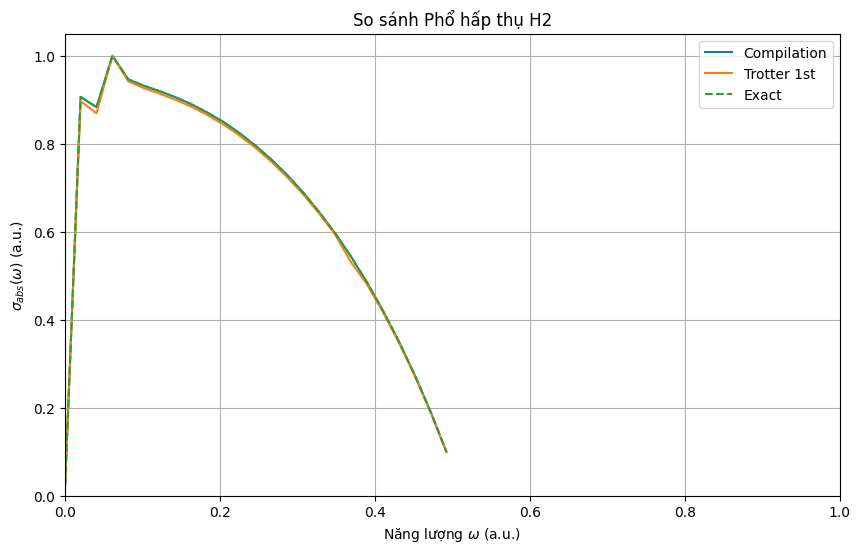

In [209]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
from scipy import fftpack
from scipy import signal
from scipy.signal import windows
from scipy.constants import speed_of_light, physical_constants

dt_fourier = times_plot_pennylane_new[1] - times_plot_pennylane_new[0]
T = 200   # change trajectory length
damping = np.pi/T
gamma = 0.001
E0 = 0.01
Gamma = 0.25

N = int(T/dt_fourier) + 1
times_plot_exact_np = np.array(times_plot_pennylane_new)
Speed_of_light_au = speed_of_light/physical_constants["atomic unit of velocity"][0]

d_z_t_pennylane_damped = muz_plot_pennylane_new
d_z_t_trotter1_damped = muz_plot_trotter_t1 
d_z_t_exact_damped = muz_plot_exact_ode 

def fourier_transform(f, dt, gamma):
    M = len(f)//2
    N = 2*M  # ensure even number of points (faster)
    c = dt/(2*np.pi)
    damped = damping(f[:N], dt, gamma)
    omega = fftpack.fftfreq(N, c)[:M]
    F = N*c*fftpack.ifft(damped, overwrite_x=True)[:M]
    return omega, F

def damping(signal, dt, gamma):
    '''damping on signal with decay rate gamma.'''
    t = np.arange(len(signal))*dt
    return signal*np.exp(-gamma*t)

def f_t_lorentz(t, E0, Gamma):
    return (E0 / np.pi) * Gamma / (Gamma**2 + t**2)

Ez = f_t_lorentz(times_plot_exact_np, E0, Gamma)    
Ez_comp = fourier_transform(Ez, dt_fourier, gamma)
Ez_fourier = E0*np.exp(-Gamma*omega)

def absorption_spectrum( mu_z, omega, F, normalize=True):
    S = omega*np.imag((mu_z)/F)
    if normalize:
        return S/S.max()
    else:
        return 4*np.pi/(Speed_of_light_au)*S
    
def discrete_spectrum(dipole_moment, dt, F, gamma, normalize=True):
    '''Absorption spectrum using a discrete Fourier transform
    '''
    # omega, mu_x = fourier_transform(dipole_moment[0], dt, gamma)
    # omega, mu_y = fourier_transform(dipole_moment[1], dt, gamma)
    omega, mu_z = fourier_transform(dipole_moment, dt, gamma)
    #omega, F = fourier_transform(F, dt, gamma)
    Ez_fourier = E0*np.exp(-Gamma*omega)
    return omega, absorption_spectrum( mu_z, omega, Ez_fourier, normalize)



omega_pennylane, FFT_pennylane = discrete_spectrum(d_z_t_pennylane_damped, dt_fourier, Ez_fourier, gamma, normalize=True)
omega_trotter1, FFT_trotter1 = discrete_spectrum(d_z_t_trotter1_damped, dt_fourier, Ez_fourier, gamma, normalize=True)
omega_exact, FFT_exact = discrete_spectrum(d_z_t_exact_damped, dt_fourier, Ez_fourier, gamma, normalize=True) 

plt.figure(figsize=(10, 6))
plt.plot(omega_pennylane, FFT_pennylane, label='Compilation')
plt.plot(omega_trotter1, FFT_trotter1, label='Trotter 1st')
plt.plot(omega_exact, FFT_exact, label='Exact', linestyle='--')
plt.xlabel("Năng lượng $\omega$ (a.u.)") # Thay đổi nhãn trục x
plt.ylabel("$\\sigma_{abs}(\\omega)$ (a.u.)")
plt.title("So sánh Phổ hấp thụ H2")
plt.legend()
plt.grid(True)

plt.xlim(0, 1) # Giới hạn trục x cho đơn vị a.u. (ví dụ: 0 đến 1 Hartree)
plt.ylim(bottom=0)
plt.show()


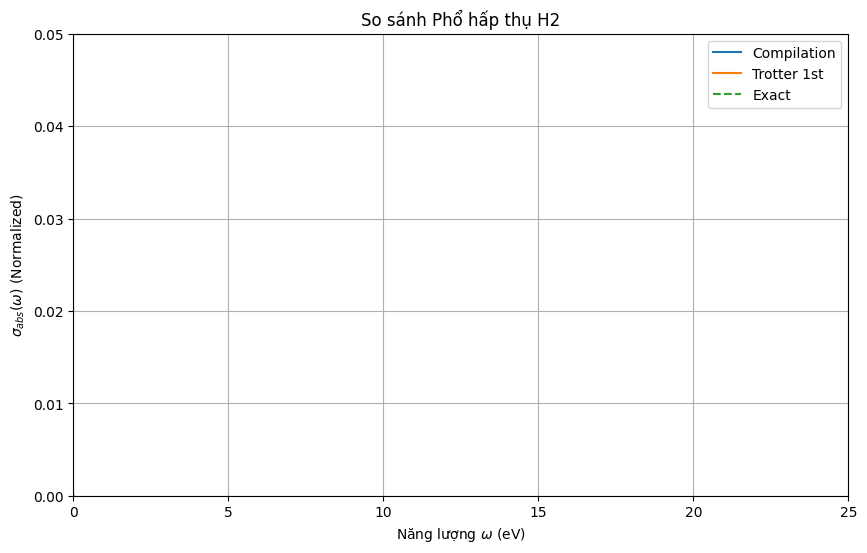

In [208]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
from scipy.constants import speed_of_light, physical_constants

# --- 1. Tham số ---
dt_fourier = times_plot_pennylane_new[1] - times_plot_pennylane_new[0]
T = 200
gamma = 0.001
E0 = 0.01
Gamma = 0.25
Speed_of_light_au = speed_of_light / physical_constants["atomic unit of velocity"][0]
N_points = len(times_plot_pennylane_new)

# --- 2. Tín hiệu trong miền thời gian ---
def f_t_lorentz(t, E0, Gamma):
    return (E0 / np.pi) * Gamma / (Gamma**2 + t**2)

times_vector = np.array(times_plot_pennylane_new)
Ez_t = f_t_lorentz(times_vector, E0, Gamma)

d_z_t_pennylane = muz_plot_pennylane_new
d_z_t_trotter1 = muz_plot_trotter_t1
d_z_t_exact = muz_plot_exact_ode

# --- 3. Xử lý tín hiệu đồng bộ (Damping) ---
# Áp dụng cùng một hàm tắt dần cho tất cả các tín hiệu
damping_factor = np.exp(-gamma * times_vector)

Ez_t_damped = Ez_t * damping_factor
d_z_t_pennylane_damped = d_z_t_pennylane * damping_factor
d_z_t_trotter1_damped = d_z_t_trotter1 * damping_factor
d_z_t_exact_damped = d_z_t_exact * damping_factor

# --- 4. Thực hiện FFT nhất quán ---
# Tạo trục tần số
omega = fftfreq(N_points, dt_fourier) * 2 * np.pi

# Thực hiện FFT cho tất cả các tín hiệu đã được xử lý
E_omega = fft(Ez_t_damped) * dt_fourier
d_omega_pennylane = fft(d_z_t_pennylane_damped) * dt_fourier
d_omega_trotter1 = fft(d_z_t_trotter1_damped) * dt_fourier
d_omega_exact = fft(d_z_t_exact_damped) * dt_fourier

# --- 5. Hàm tính phổ hấp thụ ---
def calculate_absorption(d_omega, E_omega, omega, normalize=True):
    alpha = np.zeros_like(d_omega, dtype=complex)
    # Tránh chia cho 0
    valid_indices = np.abs(E_omega) > 1e-9
    alpha[valid_indices] = d_omega[valid_indices] / E_omega[valid_indices]
    
    sigma = (4 * np.pi / Speed_of_light_au) * omega * np.imag(alpha)
    
    if normalize and np.max(np.abs(sigma)) > 0:
        return sigma / np.max(np.abs(sigma))
    return sigma

# --- 6. Tính toán kết quả cuối cùng ---
sigma_pennylane = calculate_absorption(d_omega_pennylane, E_omega, omega)
sigma_trotter1 = calculate_absorption(d_omega_trotter1, E_omega, omega)
sigma_exact = calculate_absorption(d_omega_exact, E_omega, omega)

# --- 7. Vẽ đồ thị (sử dụng fftshift để căn chỉnh tần số) ---
omega_shifted = fftshift(omega)
sigma_pennylane_shifted = fftshift(sigma_pennylane)
sigma_trotter1_shifted = fftshift(sigma_trotter1)
sigma_exact_shifted = fftshift(sigma_exact)

# Chỉ vẽ tần số dương
positive_freq_mask = omega_shifted >= 0

hartree_to_ev = 27.2114
omega_ev = omega_shifted[positive_freq_mask] * hartree_to_ev

plt.figure(figsize=(10, 6))
plt.plot(omega_ev, sigma_pennylane_shifted[positive_freq_mask], label='Compilation')
plt.plot(omega_ev, sigma_trotter1_shifted[positive_freq_mask], label='Trotter 1st')
plt.plot(omega_ev, sigma_exact_shifted[positive_freq_mask], label='Exact', linestyle='--')
plt.xlabel("Năng lượng $\omega$ (eV)")
plt.ylabel("$\\sigma_{abs}(\\omega)$ (Normalized)")
plt.title("So sánh Phổ hấp thụ H2")
plt.legend()
plt.grid(True)
plt.xlim(0, 25)
plt.ylim(bottom=0)
plt.show()

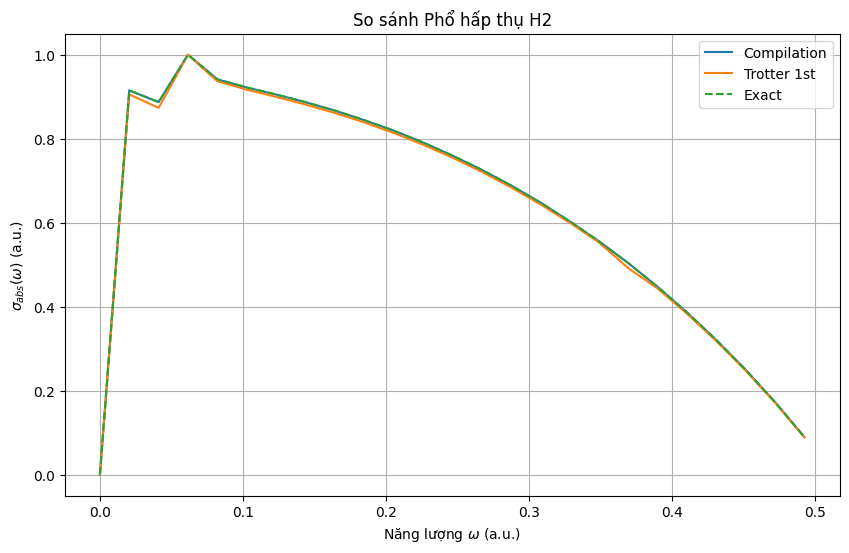

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
from scipy import fftpack
from scipy import signal
from scipy.signal import windows
from scipy.constants import speed_of_light, physical_constants

# 1. Xác định các tham số chung
if len(times_plot_pennylane_new) < 2:
    print("Lỗi: Cần ít nhất 2 điểm thời gian để thực hiện FFT.")
else:
    dt_fourier = times_plot_pennylane_new[1] - times_plot_pennylane_new[0]
    N_points = len(times_plot_pennylane_new)
    times_plot_exact_np = np.array(times_plot_pennylane_new)

    # 2. Chuẩn bị các tín hiệu E(t) và d(t)
    Speed_of_light_au = speed_of_light/physical_constants["atomic unit of velocity"][0]

    # --- THÊM HỆ SỐ DAMPING ---
    # Hệ số damping này sẽ làm rộng đỉnh phổ một cách tự nhiên.
    # Bạn có thể điều chỉnh giá trị này để xem độ rộng đỉnh thay đổi thế nào.
    # gamma = 0.001 là một giá trị khởi đầu tốt.
    gamma = 0.001
    # damping_factor = np.exp(-gamma * times_plot_exact_np)
    # --------------------------
   

    def fourier_transform(f, dt, gamma):
        M = len(f)//2
        N = 2*M  # ensure even number of points (faster)
        c = dt/(2*np.pi)
        damped = damping(f[:N], dt, gamma)
        omega = fftpack.fftfreq(N, c)[:M]
        F = N*c*fftpack.ifft(damped, overwrite_x=True)[:M]
        return omega, F
    
    def fourier_transform_no_damping(f, dt):
        '''Calculate Fourier transform without damping.'''
        M = len(f)//2
        N = 2*M  # Đảm bảo số điểm chẵn
        c = dt/(2*np.pi)
        
        # Tính toán trục tần số góc
        omega = fftpack.fftfreq(N, c)[:M]
        
        # Áp dụng ifft trực tiếp lên tín hiệu gốc f[:N] thay vì tín hiệu 'damped'
        # Các hệ số nhân được giữ nguyên để nhất quán với code gốc
        F = N*c*fftpack.ifft(f[:N], overwrite_x=True)[:M]
        
        return omega, F


    def damping(signal, dt, gamma):
        '''damping on signal with decay rate gamma.'''
        t = np.arange(len(signal))*dt
        return signal*np.exp(-gamma*t)
    
    # Áp dụng damping cho các tín hiệu lưỡng cực
    # d_z_t_pennylane_damped = muz_plot_pennylane_new * damping_factor
    # d_z_t_trotter1_damped = muz_plot_trotter_t1 * damping_factor
    # d_z_t_exact_damped = muz_plot_exact_ode * damping_factor

    # Áp dụng hàm cửa sổ (windowing) cho các tín hiệu đã có damping
    # window = windows.blackman(N_points)
    # d_z_t_pennylane_windowed = d_z_t_pennylane_damped * window
    # d_z_t_trotter1_windowed = d_z_t_trotter1_damped * window
    # d_z_t_exact_windowed = d_z_t_exact_damped * window

    # Tín hiệu trường điện từ (giống nhau cho cả hai trường hợp)
    def f_t_lorentz(t, E0, Gamma):
        return (E0 / np.pi) * Gamma / (Gamma**2 + t**2)

    E0 = 0.01
    Gamma = 0.25
    electric_field_z_t = f_t_lorentz(times_plot_exact_np, E0, Gamma)

    # E_z_t_windowed = electric_field_z_t * window

    # 3. Thực hiện FFT
    # d_z_omega_pennylane = fft(d_z_t_pennylane_windowed)
    # d_z_omega_trotter1 = fft(d_z_t_trotter1_windowed)
    # d_z_omega_exact = fft(d_z_t_exact_windowed)
    # E_z_omega_full = fft(E_z_t_windowed)

    # 4. Xử lý tần số và tính alpha, sigma cho cả hai trường hợp
    # omega_fft_full = fftfreq(N_points, dt_fourier) * 2 * np.pi
    # d_z_omega_trotter1_shifted = fftshift(d_z_omega_trotter1)
    # d_z_omega_pennylane_shifted = fftshift(d_z_omega_pennylane)
    # d_z_omega_exact_shifted = fftshift(d_z_omega_exact)
    # E_z_omega_shifted = fftshift(E_z_omega_full)
    # omega_fft_shifted = fftshift(omega_fft_full)

    # positive_freq_indices = omega_fft_shifted >= 0
    # omega_positive = omega_fft_shifted[positive_freq_indices]
    
    # Hàm pomocniczy để tính sigma
    # def calculate_sigma(d_z_omega_shifted, E_z_omega_shifted):
    #     d_z_omega_positive = d_z_omega_shifted[positive_freq_indices]
    #     E_z_omega_positive = E_z_omega_shifted[positive_freq_indices]
    #     alpha_zz_omega = np.zeros_like(d_z_omega_positive, dtype=complex)
    #     valid_E_indices = np.abs(E_z_omega_positive) > 1e-9
    #     alpha_zz_omega[valid_E_indices] = d_z_omega_positive[valid_E_indices] / E_z_omega_positive[valid_E_indices]
    #     #c_au = 137.035999084
    #     sigma = (4 * np.pi * omega_positive / Speed_of_light_au) * np.imag(alpha_zz_omega)
    #     sigma[sigma < 0] = 0
    #     return sigma
    
    def absorption_spectrum( mu_z, omega, F, normalize=True):
        S = omega*np.imag((mu_z)/F)
        if normalize:
            return S/S.max()
        else:
            return 4*np.pi/(Speed_of_light_au)*S
        
    def discrete_spectrum(dipole_moment, dt, F, gamma, normalize=True):
        '''Absorption spectrum using a discrete Fourier transform
        '''
        # omega, mu_x = fourier_transform(dipole_moment[0], dt, gamma)
        # omega, mu_y = fourier_transform(dipole_moment[1], dt, gamma)
        omega, mu_z = fourier_transform(dipole_moment, dt, gamma)
        omega, F = fourier_transform_no_damping(electric_field_z_t, dt)
        return omega, absorption_spectrum( mu_z, omega, F, normalize)
    

    # omega, F = fourier_transform_no_damping(electric_field_z_t, dt_fourier)
    # sigma_abs_pennylane = calculate_sigma(d_z_omega_pennylane_shifted, E_z_omega_shifted)
    # sigma_abs_exact = calculate_sigma(d_z_omega_exact_shifted, E_z_omega_shifted)
    # sigma_abs_trotter1 = calculate_sigma(d_z_omega_trotter1_shifted, E_z_omega_shifted)
    
    omega_pennylane, sigma_abs_pennylane = discrete_spectrum(muz_plot_pennylane_new, dt_fourier, F, gamma)
    omega_trotter1, sigma_abs_trotter1 = discrete_spectrum(muz_plot_trotter_t1, dt_fourier, F, gamma)
    omega_exact, sigma_abs_exact = discrete_spectrum(muz_plot_exact_ode, dt_fourier, F, gamma)




    # 5. Vẽ đồ thị với trục hoành là đơn vị nguyên tử (a.u.)
    # hartree_to_ev = 27.211386245988 # Không cần chuyển đổi nữa
    # omega_ev = omega_positive * hartree_to_ev

    plt.figure(figsize=(10, 6))
    plt.plot(omega_pennylane, sigma_abs_pennylane, label='Compilation')
    plt.plot(omega_trotter1, sigma_abs_trotter1, label='Trotter 1st')
    plt.plot(omega_exact, sigma_abs_exact, label='Exact', linestyle='--')
    plt.xlabel("Năng lượng $\omega$ (a.u.)") # Thay đổi nhãn trục x
    plt.ylabel("$\\sigma_{abs}(\\omega)$ (a.u.)")
    plt.title("So sánh Phổ hấp thụ H2")
    plt.legend()
    plt.grid(True)

    # plt.xlim(0, 1) # Giới hạn trục x cho đơn vị a.u. (ví dụ: 0 đến 1 Hartree)
    # plt.ylim(bottom=0)
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftfreq, fftshift
from scipy import fftpack
from scipy.signal import windows
from scipy.constants import speed_of_light, physical_constants

# ================== KIỂM TRA INPUT ===================
if len(times_plot_pennylane_new) < 2:
    raise ValueError("Cần ít nhất 2 điểm thời gian để thực hiện FFT.")

# ================== THAM SỐ ===================
dt = times_plot_pennylane_new[1] - times_plot_pennylane_new[0]
N_points = len(times_plot_pennylane_new)
times = np.array(times_plot_pennylane_new)

gamma = 0.001
E0 = 0.01
Gamma = 0.25

Speed_of_light_au = speed_of_light / physical_constants["atomic unit of velocity"][0]
T = 300 
# damping = np.pi/T
# gamma = np.pi/T

# ================== HÀM HỖ TRỢ ===================

def damping(signal, dt, gamma):
    """Áp dụng hệ số tắt dần lên tín hiệu."""
    t = np.arange(len(signal)) * dt
    return signal * np.exp(-gamma * t)

def windowed(signal):
    """Áp dụng cửa sổ Blackman để giảm ringing."""
    return signal * windows.blackman(len(signal))

def f_t_lorentz(t, E0, Gamma):
    """Trường điện từ Lorentz."""
    return (E0 / np.pi) * Gamma / (Gamma**2 + t**2)

def fourier_transform(signal, dt):
    """Fourier transform với chuẩn hóa chuẩn vật lý."""
    c = dt / (2 * np.pi)
    M = len(signal)//2
    N = 2*M  # ensure even number of points (faster)
    omega = fftpack.fftfreq(N, c)[:M]
    F = N * c * fftpack.ifft(signal[:N], overwrite_x=True)[:M]
    # N = len(signal) - (len(signal) % 2)  # làm chẵn nếu cần
    #omega = fftpack.fftfreq(N, c)[:N // 2]
    #F = N * c * fftpack.ifft(signal[:N], overwrite_x=True)[:N // 2]
    return omega, F

def absorption_spectrum(mu_omega, omega, E_omega, normalize=True):
    """Tính phổ hấp thụ từ mô men lưỡng cực và trường điện."""
    with np.errstate(divide='ignore', invalid='ignore'):
        alpha = np.zeros_like(mu_omega, dtype=complex)
        valid = np.abs(E_omega) > 1e-9
        alpha[valid] = mu_omega[valid] / E_omega[valid]
        sigma = (4 * np.pi * omega / Speed_of_light_au) * np.imag(alpha)
        sigma[sigma < 0] = 0
    return sigma / sigma.max() if normalize else sigma

def compute_discrete_spectrum(dipole_t, dt, E_t, gamma, normalize=True):
    """Tính phổ hấp thụ từ mô phỏng thời gian."""
    dipole_t = dipole_t - np.mean(dipole_t)
    dipole_damped = damping(dipole_t, dt, gamma)
    dipole_win = windowed(dipole_damped)
    E_win = windowed(E_t)

    omega, mu_omega = fourier_transform(dipole_win, dt)
    _, E_omega = fourier_transform(E_win, dt)

    sigma = absorption_spectrum(mu_omega, omega, E_omega, normalize)
    return omega, sigma

# ================== DỮ LIỆU TRƯỜNG VÀ DIPOLE ===================
E_t = f_t_lorentz(times, E0, Gamma)

# ================== TÍNH PHỔ ===================
omega1, sigma1 = compute_discrete_spectrum(muz_plot_pennylane_new, dt, E_t, gamma)
# omega2, sigma2 = compute_discrete_spectrum(muz_plot_trotter_t1, dt, E_t, gamma)
omega3, sigma3 = compute_discrete_spectrum(muz_plot_exact_ode, dt, E_t, gamma)
# omega4, sigma4 = compute_discrete_spectrum(muz_plot_trotter_t2, dt, E_t, gamma)
omega5, sigma5 = compute_discrete_spectrum(muz_plot_magnus2, dt, E_t, gamma)
hartree_to_ev = 27.211386245988
# omega_ev = omega_positive * hartree_to_ev

# ================== VẼ ĐỒ THỊ ===================
plt.figure(figsize=(10, 6))
plt.plot(omega1*hartree_to_ev, sigma1, label='Compilation')
# plt.plot(omega2*hartree_to_ev, sigma2, label='Trotter 1st')
plt.plot(omega3*hartree_to_ev, sigma3, label='Exact', linestyle='--')
# plt.plot(omega4*hartree_to_ev, sigma4, label='Trotter 2nd')
# plt.plot(omega5*hartree_to_ev, sigma5, label='Magnus 2nd')
plt.xlabel("Năng lượng $\\omega$ (eV)")
plt.ylabel("$\\sigma_{abs}(\\omega)$ (a.u)")
plt.title("So sánh Phổ hấp thụ H2")
plt.grid(True)
plt.legend()
# plt.xlim(0, 1)  # Giới hạn để tập trung vào vùng quan tâm
# plt.ylim(bottom=0)
plt.show()


NameError: name 'times_plot_pennylane_new' is not defined

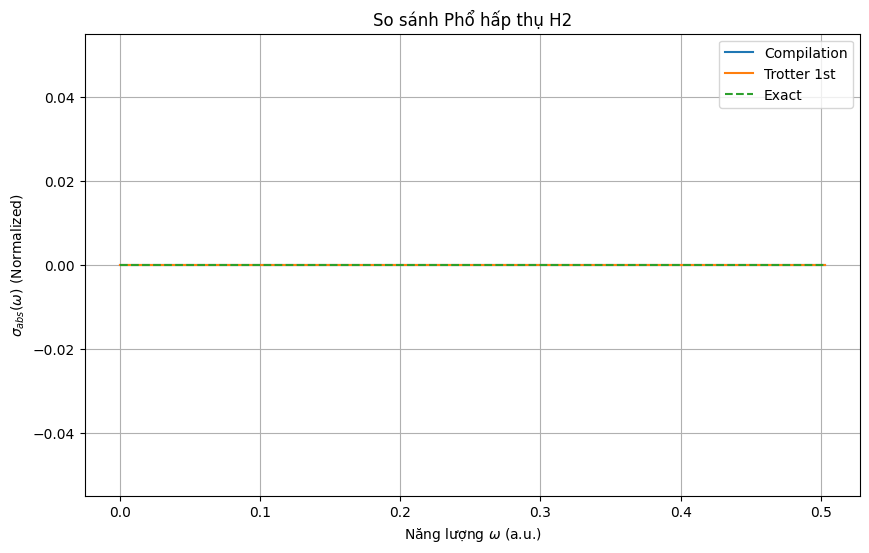

In [274]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
from scipy.constants import speed_of_light, physical_constants

# --- 1. THAM SỐ VÀ TÍN HIỆU BAN ĐẦU ---
# Giả sử các biến times_plot_pennylane_new, muz_... đã được định nghĩa
if len(times_plot_pennylane_new) < 2:
    print("Lỗi: Cần ít nhất 2 điểm thời gian.")
else:
    dt_fourier = times_plot_pennylane_new[1] - times_plot_pennylane_new[0]
    N_points = len(times_plot_pennylane_new)
    times_vector = np.array(times_plot_pennylane_new)
    
    # Các tham số vật lý
    gamma = 0.005  # Thử tăng gamma một chút để giảm đỉnh giả ở w=0
    E0 = 0.01
    Gamma = 0.25
    Speed_of_light_au = speed_of_light / physical_constants["atomic unit of velocity"][0]

    # Tín hiệu lưỡng cực (raw)
    d_z_t_pennylane = muz_plot_pennylane_new
    d_z_t_trotter1 = muz_plot_trotter_t1
    d_z_t_exact = muz_plot_exact_ode

    # Tín hiệu trường điện từ (raw)
    def f_t_lorentz(t, E0, Gamma):
        return (E0 / np.pi) * Gamma / (Gamma**2 + t**2)
    Ez_t = f_t_lorentz(times_vector, E0, Gamma)

    # --- 2. XỬ LÝ TÍN HIỆU (ÁP DỤNG DAMPING) ---
    # CHỈ áp dụng damping cho các tín hiệu moment lưỡng cực (phản hồi)
    damping_factor = np.exp(-gamma * times_vector)
    
    d_z_t_pennylane_damped = d_z_t_pennylane * damping_factor
    d_z_t_trotter1_damped = d_z_t_trotter1 * damping_factor
    d_z_t_exact_damped = d_z_t_exact * damping_factor
    
    # --- 3. THỰC HIỆN FFT (DÙNG HÀM CHUẨN VÀ NHẤT QUÁN) ---
    # Tạo trục tần số chung
    omega = fftfreq(N_points, dt_fourier) * 2 * np.pi

    # Tính FFT của trường E(t) KHÔNG DAMPING
    E_omega = fft(Ez_t) * dt_fourier

    # Tính FFT của các tín hiệu d(t) CÓ DAMPING
    d_omega_pennylane = fft(d_z_t_pennylane_damped) * dt_fourier
    d_omega_trotter1 = fft(d_z_t_trotter1_damped) * dt_fourier
    d_omega_exact = fft(d_z_t_exact_damped) * dt_fourier

    # --- 4. HÀM TÍNH PHỔ HẤP THỤ ---
    def calculate_absorption(d_omega, E_omega, omega, normalize=True):
        alpha = np.zeros_like(d_omega, dtype=complex)
        valid_indices = np.abs(E_omega) > 1e-10
        alpha[valid_indices] = d_omega[valid_indices] / E_omega[valid_indices]
        
        sigma = (4 * np.pi / Speed_of_light_au) * omega * np.imag(alpha)
        sigma[sigma < 0] = 0

        if normalize and np.max(sigma) > 0:
            return sigma / np.max(sigma)
        return sigma

    # --- 5. TÍNH TOÁN KẾT QUẢ CUỐI CÙNG ---
    sigma_pennylane = calculate_absorption(d_omega_pennylane, E_omega, omega)
    sigma_trotter1 = calculate_absorption(d_omega_trotter1, E_omega, omega)
    sigma_exact = calculate_absorption(d_omega_exact, E_omega, omega)

    # --- 6. VẼ ĐỒ THỊ ---
    omega_shifted = fftshift(omega)
    sigma_pennylane_shifted = fftshift(sigma_pennylane)
    sigma_trotter1_shifted = fftshift(sigma_trotter1)
    sigma_exact_shifted = fftshift(sigma_exact)
    
    # Chỉ lấy phần tần số dương để vẽ
    positive_freq_mask = omega_shifted >= 0
    
    plt.figure(figsize=(10, 6))
    plt.plot(omega_shifted[positive_freq_mask], sigma_pennylane_shifted[positive_freq_mask], label='Compilation')
    plt.plot(omega_shifted[positive_freq_mask], sigma_trotter1_shifted[positive_freq_mask], label='Trotter 1st')
    plt.plot(omega_shifted[positive_freq_mask], sigma_exact_shifted[positive_freq_mask], label='Exact', linestyle='--')
    
    plt.xlabel("Năng lượng $\omega$ (a.u.)")
    plt.ylabel("$\\sigma_{abs}(\\omega)$ (Normalized)")
    plt.title("So sánh Phổ hấp thụ H2")
    plt.legend()
    plt.grid(True)
    # plt.xlim(0, 1.0)
    # plt.ylim(bottom=0)
    plt.show()

Bắt đầu thực hiện Biến đổi Fourier số học...
... Hoàn tất!


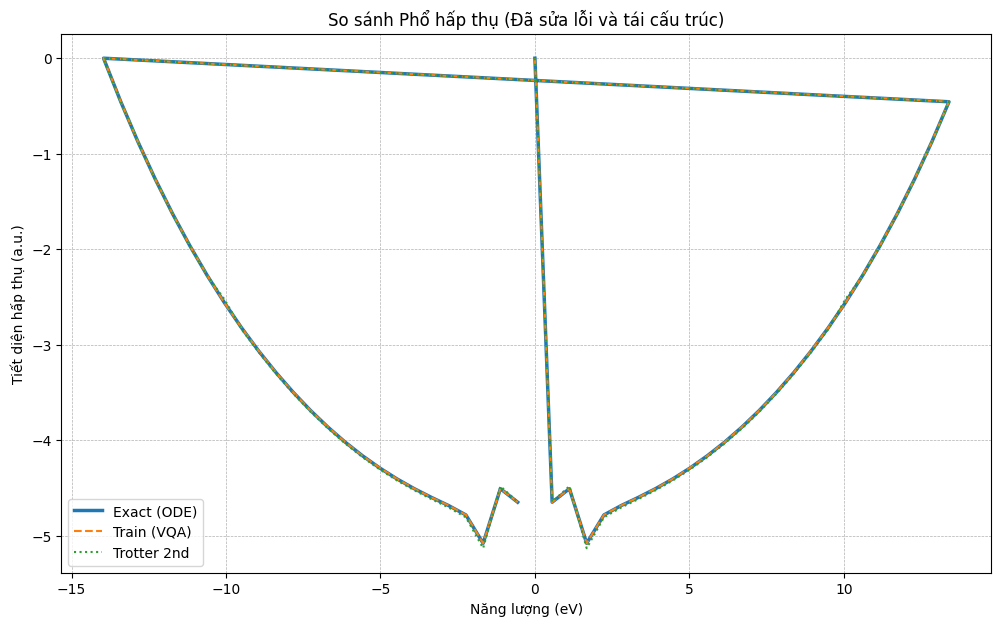

In [260]:
# CELL MỚI, ĐÃ ĐƯỢC CẬP NHẬT ĐỂ PHẢN ÁNH ĐÚNG LÝ THUYẾT

import numpy as np
from scipy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt

#======================================================================
# BƯỚC 1: CHUẨN BỊ DỮ LIỆU VÀ THAM SỐ
#======================================================================
try:
    muz_plot_exact = np.array(muz_plot_exact_ode)
    muz_plot_pennylane = np.array(muz_plot_pennylane_new)
    muz_plot_trotter1 = np.array(muz_plot_trotter_t1)
    times = np.array(times_for_training)
    
    dt = times[1] - times[0]
    gamma_decay = 0.001  # Tốc độ suy giảm cho hàm tương quan
    E0 = 0.01
    Gamma = 0.25

except NameError as e:
    print(f"Lỗi: Biến '{e.name}' chưa được định nghĩa.")
    raise

#======================================================================
# BƯỚC 2: ĐỊNH NGHĨA CÁC HÀM TÍNH TOÁN
#======================================================================

# def apply_damping(signal, dt, decay_rate):
#     """Áp dụng suy giảm exp(-gamma*t) cho tín hiệu."""
#     t = np.arange(len(signal)) * dt
#     return signal * np.exp(-decay_rate * t)

damping_factor = np.exp(-gamma_decay * times)

def calculate_fourier_transform(signal_t, dt):
    """Thực hiện biến đổi Fourier số học bằng rfft."""
    N = len(signal_t)
    F_omega = fft(signal_t) * dt
    omega = fftfreq(N, dt) * (2 * np.pi)
    return omega, F_omega

def calculate_absorption_spectrum(mu_z_omega, omega, F_omega):
    """Tính tiết diện hấp thụ."""
    alpha = mu_z_omega / F_omega
    sigma = omega * np.imag(alpha)
    return sigma

#======================================================================
# BƯỚC 3: QUY TRÌNH TÍNH TOÁN PHỔ HẤP THỤ (THEO ĐÚNG LÝ THUYẾT)
#======================================================================

# --- A. Tín hiệu trường điện từ E(t) trong miền thời gian ---
Ez_t = (E0 / np.pi) * Gamma / (Gamma**2 + times**2)

# --- B. Áp dụng Damping CHỈ cho tín hiệu dipole (đúng theo lý thuyết) ---
muz_exact_damped = muz_plot_exact * damping_factor
muz_penn_damped = muz_plot_pennylane * damping_factor
muz_trotter1_damped = muz_plot_trotter1 * damping_factor

# --- C. Thực hiện Fourier Transform số học cho TẤT CẢ các tín hiệu ---
print("Bắt đầu thực hiện Biến đổi Fourier số học...")
# FT cho dipole (đã qua damping)
omega, mu_z_omega_exact = calculate_fourier_transform(muz_exact_damped, dt)
_, mu_z_omega_penn = calculate_fourier_transform(muz_penn_damped, dt)
_, mu_z_omega_trotter1 = calculate_fourier_transform(muz_trotter1_damped, dt)

# FT cho trường E(t) (KHÔNG QUA DAMPING, nhưng vẫn dùng FT số)
_, Ez_omega_numerical = calculate_fourier_transform(Ez_t, dt)
print("... Hoàn tất!")

# --- D. Tính toán phổ hấp thụ cuối cùng ---
sigma_exact = calculate_absorption_spectrum(mu_z_omega_exact, omega, Ez_omega_numerical)
sigma_penn = calculate_absorption_spectrum(mu_z_omega_penn, omega, Ez_omega_numerical)
sigma_trotter1 = calculate_absorption_spectrum(mu_z_omega_trotter1, omega, Ez_omega_numerical)

#======================================================================
# BƯỚC 4: VẼ ĐỒ THỊ
#======================================================================
hartree_to_ev = 27.211386245988
omega_ev = omega * hartree_to_ev

plt.figure(figsize=(12, 7))
plt.plot(omega_ev, sigma_exact,    label='Exact (ODE)', linewidth=2.5)
plt.plot(omega_ev, sigma_penn,     label='Train (VQA)', linestyle='--')
plt.plot(omega_ev, sigma_trotter1, label='Trotter 2nd', linestyle=':')

plt.title('So sánh Phổ hấp thụ (Đã sửa lỗi và tái cấu trúc)')
plt.xlabel('Năng lượng (eV)')
plt.ylabel('Tiết diện hấp thụ (a.u.)')
# plt.xlim(0, 20)
# plt.ylim(bottom=0)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


In [353]:
# CELL MỚI: GHI DỮ LIỆU PHỔ HẤP THỤ (ĐÃ VẼ) RA FILE

try:
    # Tên file để lưu kết quả
    output_filename = "absorption_spectra_eV.txt"

    with open(output_filename, "w") as f:
        # Ghi dòng tiêu đề cho các cột, đơn vị là eV giống như trên đồ thị
        f.write("# Energy (eV)   Sigma_Exact (a.u.) Sigma_Compilation (a.u.)     Sigma_Trotter1 (a.u.)   Sigma_Trotter2 (a.u.)   Sigma_Magnus2 (a.u.)\n")
        
        # Lặp qua dữ liệu đã tính toán và ghi ra file
        # omega_ev, sigma_abs_pennylane, sigma_abs_exact là các biến từ ô code vẽ đồ thị
        for i in range(len(omega_ev)):
            energy_val = omega_ev[i]
            sigma_pennylane = sigma1[i]
            sigma_trotter1 = sigma2[i]
            sigma_exact = sigma3[i]
            sigma_trotter2 = sigma4[i]
            sigma_magnus2 = sigma5[i]
            
            # Định dạng và ghi một dòng dữ liệu
            f.write(f"{energy_val:<15.6f}{sigma_exact:<21.12f} {sigma_pennylane:<26.12f}  {sigma_trotter1:<21.12f} {sigma_trotter2:<21.12f} {sigma_magnus2:<21.12f}\n")
            
    print(f"Đã lưu dữ liệu phổ hấp thụ thành công vào file: {output_filename}")

except NameError:
    print("Lỗi: Không tìm thấy các biến cần thiết (omega_ev, sigma_abs_pennylane, sigma_abs_exact).")
    print("Vui lòng đảm bảo bạn đã chạy ô code tính toán và vẽ đồ thị phổ hấp thụ ngay trước khi chạy ô này.")
except Exception as e:
    print(f"Đã xảy ra lỗi không mong muốn: {e}")

Đã lưu dữ liệu phổ hấp thụ thành công vào file: absorption_spectra_eV.txt


In [35]:
# CELL MỚI: TÍNH TOÁN VÀ VẼ ĐỒ THỊ FIDELITY (ĐÃ SỬA LỖI)
import numpy as np
import matplotlib.pyplot as plt

try:
    # --- Bước 1: Lấy dữ liệu đã được tính toán (phải là list) ---
    psi_train_list = all_psi_t_pennylane_new
    psi_exact_list = all_psi_t_exact_ode
    times = times_for_training

    # Kiểm tra lại để chắc chắn các biến là list và có cùng độ dài
    if not (isinstance(psi_train_list, list) and isinstance(psi_exact_list, list)):
         raise TypeError("Dữ liệu trạng thái phải ở dạng list, không phải dictionary.")
    if len(psi_train_list) != len(psi_exact_list) or len(psi_train_list) != len(times):
        raise ValueError("Số lượng điểm dữ liệu của 'train', 'exact' và 'times' không khớp.")

    # --- Bước 2: Tính toán Fidelity tại mỗi điểm thời gian ---
    fidelities = []
    # **SỬA LỖI Ở ĐÂY: Lặp qua chỉ số nguyên 'i' thay vì thời gian 't'**
    for i in range(len(times)):
        # Truy cập bằng chỉ số nguyên
        psi_train = psi_train_list[i]
        psi_exact = psi_exact_list[i]
        
        # Tính tích trong (inner product)
        # psi_exact.conj() là liên hợp phức của vector trạng thái
        inner_product = np.dot(psi_exact.conj(), psi_train)
        
        # Tính fidelity (bình phương của module)
        fidelity = np.abs(inner_product)**2
        fidelities.append(fidelity)
        
    print("Tính toán Fidelity thành công.")

    # --- Bước 3: Vẽ đồ thị Fidelity ---
    plt.figure(figsize=(10, 6))
    plt.plot(times, fidelities, label='Fidelity (Train vs Exact)', color='green', marker='.', linestyle='-')
    plt.xlabel("Thời gian (a.u.)", fontsize=12)
    plt.ylabel("Fidelity F = |<ψ_exact|ψ_train>|²", fontsize=12)
    plt.title("Độ trung thực của Trạng thái VQA so với Trạng thái Chính xác", fontsize=16)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.ylim([0, 1.05]) # Fidelity luôn nằm trong khoảng [0, 1]
    plt.show()

except NameError as e:
    print(f"Lỗi: Không tìm thấy biến cần thiết để tính toán. Chi tiết: {e}")
    print("Vui lòng đảm bảo các ô code trước (tính exact_ode và train_vqa) đã được chạy thành công.")
except Exception as e:
    print(f"Đã xảy ra lỗi không mong muốn: {e}")


Đã xảy ra lỗi không mong muốn: Dữ liệu trạng thái phải ở dạng list, không phải dictionary.


In [63]:
# CELL MỚI: TÍNH VÀ LƯU FIDELITY (TRAIN vs EXACT) RA FILE TXT

import numpy as np

output_filename = "fidelity_train_vs_exact.txt"

try:
    # --- Bước 1: Chuẩn hóa dữ liệu đầu vào ---
    # Đảm bảo `all_psi_t_pennylane_new` được chuyển sang dạng list
    # để tương thích với `all_psi_t_exact_ode`
    if isinstance(all_psi_t_pennylane_new, dict):
        print("Phát hiện `all_psi_t_pennylane_new` là dictionary. Đang chuyển đổi sang list...")
        sorted_times = sorted(all_psi_t_pennylane_new.keys())
        psi_train_list = [all_psi_t_pennylane_new[t] for t in sorted_times]
    else:
        print("`all_psi_t_pennylane_new` đã là list.")
        # Giả định biến times_for_training tồn tại nếu `all_psi_t_pennylane_new` là list
        sorted_times = times_for_training 
        psi_train_list = all_psi_t_pennylane_new
        
    # Giả định `all_psi_t_exact_ode` đã là một list/array có thể truy cập bằng chỉ số nguyên
    psi_exact_list = all_psi_t_exact_ode

    # Kiểm tra độ dài để đảm bảo tính toán chính xác
    if len(psi_train_list) != len(psi_exact_list):
        raise ValueError(f"Lỗi: Số lượng trạng thái 'train' ({len(psi_train_list)}) và 'exact' ({len(psi_exact_list)}) không khớp nhau.")

    # --- Bước 2: Tính toán Fidelity ---
    print("Đang tính toán Fidelity...")
    fidelities = []
    for i in range(len(psi_train_list)):
        psi_exact = psi_exact_list[i]
        psi_train = psi_train_list[i]
        
        # Công thức: F = |<psi_exact|psi_train>|^2
        inner_product = np.dot(np.conj(psi_exact), psi_train)
        fidelity = np.abs(inner_product)**2
        fidelities.append(fidelity)
    
    # --- Bước 3: Ghi kết quả ra file ---
    print(f"Đang ghi kết quả ra file '{output_filename}'...")
    with open(output_filename, "w") as f:
        # Ghi dòng tiêu đề cho các cột
        f.write("# Time (fs)   Fidelity\n")
        
        # Ghi dữ liệu từng dòng, căn chỉnh cho đẹp
        for i in range(len(sorted_times)):
            f.write(f"{sorted_times[i]:<15.8f} {fidelities[i]:<15.8f}\n")
            
    print(f"\nHoàn tất! Đã lưu thành công dữ liệu Fidelity vào file '{output_filename}'.")
    print("File chứa 2 cột: Thời gian và Fidelity.")

except Exception as e:
    print(f"Đã xảy ra lỗi không mong muốn: {e}")
    print("Vui lòng đảm bảo các biến `all_psi_t_pennylane_new` và `all_psi_t_exact_ode` đã được tính toán ở các ô trước.")


Phát hiện `all_psi_t_pennylane_new` là dictionary. Đang chuyển đổi sang list...
Đang tính toán Fidelity...
Đang ghi kết quả ra file 'fidelity_train_vs_exact.txt'...

Hoàn tất! Đã lưu thành công dữ liệu Fidelity vào file 'fidelity_train_vs_exact.txt'.
File chứa 2 cột: Thời gian và Fidelity.


Đang chuyển đổi dictionary `all_psi_t_pennylane_new` sang list...
Chuyển đổi hoàn tất.


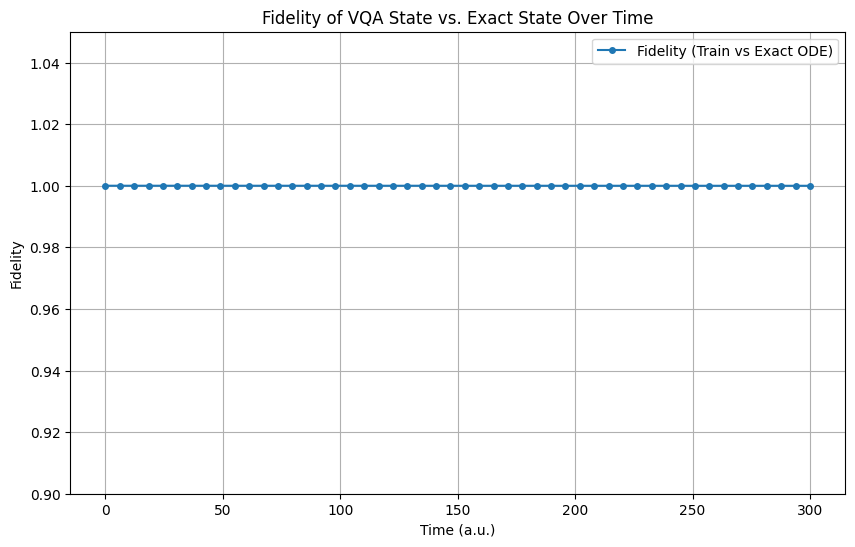

In [36]:
# CELL MỚI: CHUYỂN ĐỔI DICTIONARY SANG LIST VÀ VẼ FIDELITY

import numpy as np
import matplotlib.pyplot as plt

try:
    # --- Bước 1: Chuyển đổi all_psi_t_pennylane_new từ dictionary sang list ---
    # Giả định `all_psi_t_pennylane_new` đang là một dictionary từ lần chạy trước.
    
    print("Đang chuyển đổi dictionary `all_psi_t_pennylane_new` sang list...")
    # Lấy các khóa (thời gian) và sắp xếp chúng
    sorted_times = sorted(all_psi_t_pennylane_new.keys())
    
    # Tạo list mới chứa các vector trạng thái theo đúng thứ tự thời gian
    psi_train_list = [all_psi_t_pennylane_new[t] for t in sorted_times]
    print("Chuyển đổi hoàn tất.")

    # --- Bước 2: Tính toán Fidelity ---
    # Giả định `all_psi_t_exact_ode` đã là một list/array từ trước
    num_time_steps = len(psi_train_list)
    fidelities = []

    for i in range(num_time_steps):
        # Bây giờ cả hai đều có thể truy cập bằng chỉ số nguyên `i`
        psi_exact = all_psi_t_exact_ode[i]
        psi_train = psi_train_list[i]

        inner_product = np.dot(np.conj(psi_exact), psi_train)
        fidelity = np.abs(inner_product)**2
        fidelities.append(fidelity)

    # --- Bước 3: Vẽ đồ thị ---
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_times, fidelities, marker='o', linestyle='-', markersize=4, label='Fidelity (Train vs Exact ODE)')
    plt.xlabel("Time (a.u.)")
    plt.ylabel("Fidelity")
    plt.title("Fidelity of VQA State vs. Exact State Over Time")
    plt.ylim(min(0.9, np.min(fidelities) - 0.05), 1.05)
    plt.grid(True)
    plt.legend()
    plt.show()

except Exception as e:
    print(f"Đã xảy ra lỗi: {e}")
    print("Vui lòng đảm bảo rằng biến `all_psi_t_pennylane_new` (dạng dictionary) đã tồn tại từ các ô trước.")


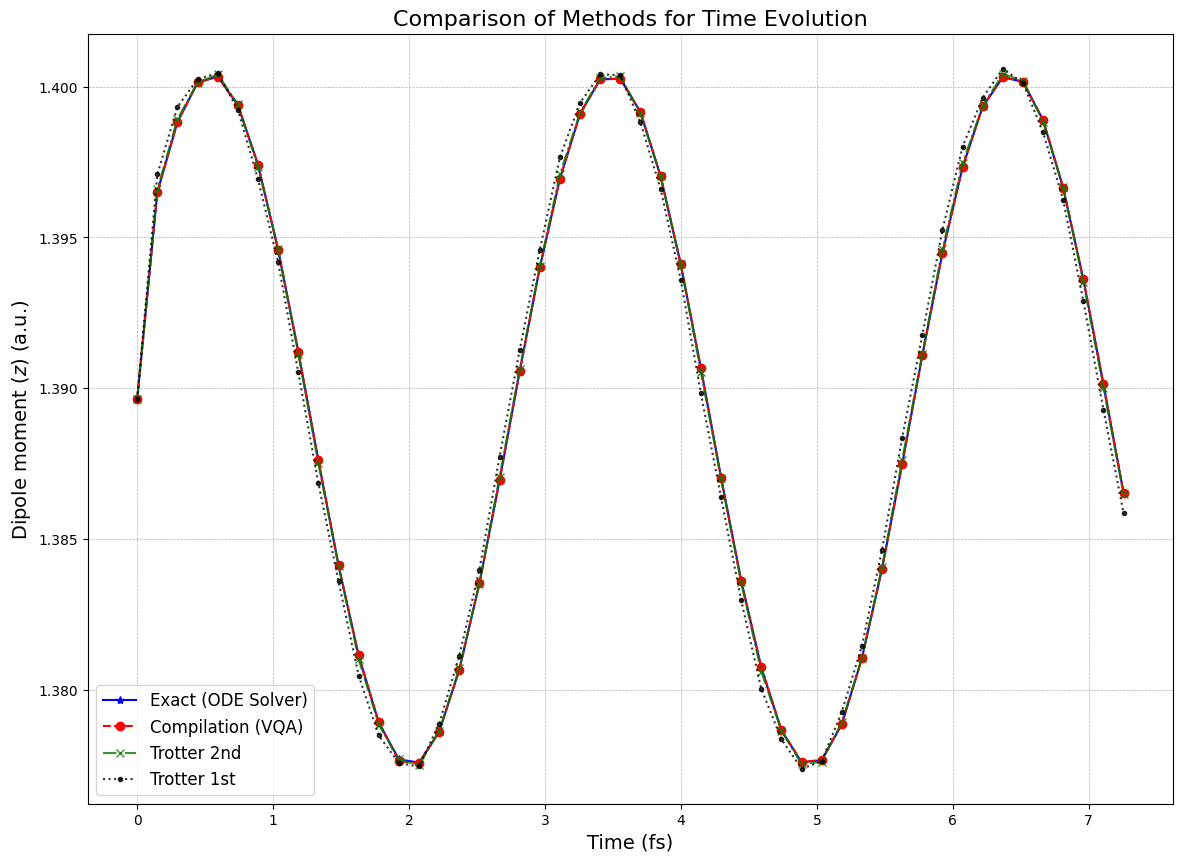

In [362]:
# CELL MỚI: VẼ LẠI ĐỒ THỊ VỚI TRỤC THỜI GIAN THEO FEMTO-GIÂY (fs)

import matplotlib.pyplot as plt
import numpy as np

try:
    # --- Bước 1: Chuyển đổi đơn vị thời gian ---
    # Hằng số chuyển đổi từ a.u. (thời gian) sang femto-giây
    au_to_fs = 0.0241888

    # Tạo mảng thời gian mới với đơn vị là fs
    times_in_fs = np.array(times_for_training) * au_to_fs

    # --- Bước 2: Vẽ đồ thị với dữ liệu đã chuyển đổi ---
    plt.figure(figsize=(14, 10))

    # Dùng `times_in_fs` để vẽ
    plt.plot(times_in_fs, muz_plot_exact_ode, label="Exact (ODE Solver)", color='blue',marker='*', linestyle='-')
    plt.plot(times_in_fs, muz_plot_pennylane_new, label="Compilation (VQA)", linestyle='--', marker='o', color='red', markersize=6)
    if 'muz_plot_trotter_t2' in locals():
        plt.plot(times_in_fs, muz_plot_trotter_t2, label="Trotter 2nd", linestyle='-.',marker ='x', color='green', alpha=0.8)
    # if 'muz_plot_magnus2' in locals():
    #     plt.plot(times_in_fs, muz_plot_magnus2, label="Magnus 2nd", linestyle='--',marker ='^', color='purple', alpha=0.7)
    if 'muz_plot_trotter_t1' in locals():
        plt.plot(times_in_fs, muz_plot_trotter_t1, label="Trotter 1st", linestyle=':', marker='.', color='black', alpha=0.8)

    # --- Định dạng đồ thị ---
    # Nhãn bây giờ đã chính xác
    plt.xlabel("Time (fs)", fontsize=14)
    plt.ylabel("Dipole moment ($z$) (a.u.)", fontsize=14)
    plt.title("Comparison of Methods for Time Evolution", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

except NameError:
    print("Lỗi: Không tìm thấy các biến dữ liệu cần thiết. Vui lòng chạy các ô tính toán trước.")
